## Let's build a Multimodal LLM from scratch!
This isn't about the hype, this is truly for lovers of LLMs and the actual math behind it. If you're one of them, you're more than welcome to join my [discord server](https://discord.gg/PRs84AnxtT)!

### But what is a LLM anyway?

A Large Language Model (LLM) is a type of artificial intelligence model designed to understand, generate, and manipulate human language. These models are trained on vast amounts of text data and can perform a wide variety of language tasks such as translation, summarization, question answering, and text generation.

For a more in-depth understanding, check out this explanatory video:

[[ 1 hr Talk ] Intro to Large Language Models by Andrej Karpathy](https://www.youtube.com/embed/zjkBMFhNj_g)

<iframe width="560" height="315" src="https://www.youtube.com/embed/zjkBMFhNj_g" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



---

#### *Note*
This project is solely for my learning purpose and love for artificial intelligence, I do not plan to advertise, boast or take advantage of people for helping on this project. You're more than welcome to use this project in our resume or anywhere you'd like as a collaborator for credit.

---

## Index

| Name | Description |  
|-------|------|
| **Pre-requisites** | Setting Up Environment | 
| **1. Text-based LLM**  | Understanding data and its importance |
|  | Evolution of Large Language Models | 
|  | Introduction to Modern Transformers |
|  | Experiment with different architectural techniques |
|  | Training the model |
|  | Evaluating the model |
|  | Optimization techniques |
|  | Model attention pattern Visualization |
|  | Exporting best model |
| **2. Multimodal LLM** | Introduction to multimodal learning and model visualization |
|  | Understanding multimodal data and it's importance |
|  | Foundational Patterns with Multimodal LLMs |
|  | Experiment with different architectural techniques |
|  | Training the multimodal |
|  | Evaluating the mulitmodal |
|  | Advanced techniques |
|  | Multimodal attention pattern Visualization |
|  | Exporting best model |
| **3. Ending Notes** |  Final edits, error analysis, and future work |


## Preq-requisites

A bit of interest and patience to learning will help.

## Environment Setup

1. Create python environment `python -m venv venv`
2. Install dependencies `pip install -r requirements.txt`
3. Login with our [huggingface account](https://huggingface.co/docs/hub/datasets-usage)
4. Searching for best possible text data given our time, commitment and constraints. We'll use [TinyStories dataset](https://huggingface.co/datasets/roneneldan/TinyStories) for text and [soon] for image-text since it's really high quality and easy to train
5. Here's how I have divided my project structure and pipeline
```
├── models/              # Encoders & fusion layers
├── data/                # Processing scripts
├── training/            # Contrastive loss implementation
├── explainability/      # Attention visualization tools
├── demo/                # Gradio interface
```

In [ ]:
%pip install --quiet --upgrade pip
%pip install --quiet -r requirements.txt
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Login with HuggingFace using token from environment variables
from huggingface_hub import login
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get token from environment variables
huggingface_token = os.getenv("HUGGING_FACE_TOKEN")

# Login with our token
login(token=huggingface_token, add_to_git_credential=True)


---
## (Optional) Evolution of Large Language Models

Language models have undergone a remarkable evolution over the past few decades. Let's trace this progression to understand how we arrived at today's powerful transformer-based LLMs.

---

### 1. **Rule-Based Systems (1950s-1980s)** 

Rule-based systems emerged in the 1950s and 1960s as the first serious attempt to make computers understand and generate human language. These systems, like ELIZA and SHRDLU, relied on manually crafted rules and pattern-matching logic to simulate conversation or parse commands. At the time, this approach was necessary because computers were extremely limited in memory and processing power, and there was no practical way to “learn” language from data. Instead, engineers and linguists painstakingly encoded linguistic patterns and world knowledge into the system, allowing it to respond to specific phrases or commands in constrained scenarios.

Despite their ingenuity, rule-based systems faced fundamental limitations that ultimately made them impractical for real-world language understanding. Their logic was brittle: they could only handle inputs that matched their predefined rules, and any unexpected phrasing or new vocabulary would cause them to fail. Scaling these systems to handle more complex or open-ended conversations required an explosion of rules, making development and maintenance prohibitively time-consuming and expensive. Furthermore, these systems lacked the ability to learn or adapt on their own; every update or expansion had to be done manually, leaving them unable to keep pace with evolving language or new contexts.

ELIZA demonstrated remarkable effectiveness in specific, constrained scenarios while failing dramatically in open-ended conversations. In therapy-like exchanges, ELIZA's pattern-matching excelled: when a user typed "I am feeling depressed," ELIZA would recognize the "I am [X]" pattern and respond with "Why do you think you are feeling depressed?"-creating an illusion of understanding that was convincing enough to pass a limited Turing test (even outperforming GPT-3.5 in a 2023 study). However, ELIZA collapsed when conversations moved beyond its programmed patterns. For instance, if a user said "My mother-in-law is visiting next week," ELIZA might respond with "Tell me more about our family"-completely missing the contextual nuance and emotional content that might be present. This stark contrast between success in narrow domains and failure in broader contexts highlighted the fundamental limitations of rule-based approaches and ultimately drove the field toward statistical methods that could learn from data.

The legacy of rule-based systems is both instructive and cautionary. While they pioneered key concepts in natural language processing-such as dialogue management and symbolic reasoning-their inflexibility and the combinatorial explosion of rules made it clear that a different approach was needed. This set the stage for the development of statistical and, later, neural language models, which could learn patterns from data and generalize to new inputs without explicit programming. In this way, rule-based systems laid the groundwork for modern AI while also highlighting the need for more flexible, scalable solutions.


### 2. **Statistical Revolution (1990s-2010s)**  

The statistical revolution emerged as a response to the inflexibility of rule-based systems, driven by the need to handle language’s inherent variability through probabilistic reasoning rather than rigid logic. Researchers shifted focus to algorithms that could *learn* patterns from data, leveraging growing computational power and newly available digital text corpora. This era saw language modeling framed as a probability estimation problem, where systems predicted words based on observed frequencies rather than handcrafted rules.  

N-gram models became the workhorse of this revolution, operating on a simple premise: the probability of a word depends only on the last *N-1* words. For example, a trigram model calculated $ P(wₙ | wₙ₋₁, wₙ₋₂) $ which allowed it to predict "fox" after "the quick brown." These models thrived in applications like early speech recognition, where predicting "phone" after "cellular" improved accuracy in voice-to-text systems. However, their limitations became glaringly apparent at scale. A vocabulary of 20,000 words required 400 million entries for bigrams and 8 trillion for trigrams-numbers that exhausted 1990s storage capabilities. Even with aggressive smoothing techniques, 30% of valid phrases remained unobserved in training data, forcing models to guess blindly.  

Hidden Markov Models (HMMs) attempted to address these issues by introducing latent states for tasks like part-of-speech tagging. In a POS tagger, a "verb" state might emit "running" with 70% probability, while a "noun" state emitted "dog" with 85% likelihood. This worked well for narrow tasks like parsing structured sentences in technical manuals. However, HMMs faltered with ambiguous phrasing-in "Time flies like an arrow," they struggled to disambiguate whether "flies" was a verb or noun because their Markov assumption ignored context beyond the immediate state.  

A telling example of statistical models’ mixed success lies in early email spam filters. N-gram models excelled at flagging messages containing "free money" or "credit card," achieving 95% accuracy on patterned spam. But they failed catastrophically with creative phishing attempts like "our account needs verification" (where "verification" appeared legitimate in other contexts), demonstrating their inability to grasp semantic intent. Similarly, HMM-based speech recognizers transcribed "recognize speech" flawlessly but mangled "wreck a nice beach" into nonsensical outputs, exposing their reliance on surface-level patterns rather than meaning.  

The statistical era ultimately highlighted a fundamental tension: while frequency-based approaches scaled better than rules, they remained shackled to superficial patterns. Models could mimic local syntactic structures but failed to capture the semantic depth or contextual flexibility that defines human language. This realization, coupled with advances in neural network theory, paved the way for architectures that could learn *distributed representations* of meaning-setting the stage for the neural revolution that would follow.


### 3. **Neural Dawn (2000s-2017)**  

![Transformer attention mechanism](assets/attention.png)


The neural dawn marked a paradigm shift from statistical counting to learned representations, driven by advances in computational power and distributed vector spaces. This era bridged the gap between rigid rule-based systems and today’s transformer models, using neural networks to encode language into continuous vectors rather than discrete symbols or counts.  

**Word2Vec (2013)** revolutionized how machines understood meaning by mapping words to dense 300-dimensional vectors. Unlike n-grams that treated "bank" and "riverbank" as unrelated, Word2Vec learned that these words share semantic neighbors like "water" and "money," enabling analogies like *king - man + woman ≈ queen*. This worked because words appearing in similar contexts (e.g., "deposit" for both financial and geological "banks") were pushed closer in vector space. However, this strength became a weakness with polysemous words: "apple" had the same vector whether referring to fruit or the tech company, forcing models to conflate unrelated meanings. Early search engines used these embeddings to improve query understanding but struggled with niche terms like "GPU acceleration," which appeared too infrequently in training corpora.  

**LSTMs/GRUs** addressed RNNs’ fatal flaw: the vanishing gradient problem. By introducing gating mechanisms (forget, input, output gates), they could retain critical information over hundreds of steps. For example, in translating "The cat sat on the mat, which was old," LSTMs preserved "cat" across the sentence to correctly gender pronouns in languages like French. But their sequential nature made them slow-processing a 500-word article took 500 sequential steps, creating bottlenecks. A 2016 study found LSTMs achieved 92% accuracy on sentence completion but required 3 seconds per sentence versus transformers’ 0.2 seconds (ACL Anthology). GRUs simplified this by merging gates, trading some long-range memory for faster training, but both architectures remained fundamentally limited by their O(n) time complexity.  

The **attention mechanism** (2015) was the final breakthrough before transformers. By letting models dynamically focus on relevant context, it solved the "fixed window" problem. In early implementations, an RNN with attention translating "She poured water from the *pitcher* into the *glass*" could attend to "pitcher" when generating "vaso" (glass) in Spanish, even if the words were 20 tokens apart. However, hybrid attention-RNN systems still struggled with computational complexity-each attention step required O(n²) operations for sequence length n. For a 1,000-token document, this meant 1 million operations per layer, limiting real-world usability.  

**Legacy**: These innovations laid the groundwork for transformers by proving three key principles:  
1. Distributed representations (Word2Vec) could encode semantic relationships  
2. Gating mechanisms (LSTMs) enabled long-term memory  
3. Attention allowed dynamic context focus  

### 4. **Transformer Era (2017-Present)**  

![OpenAI Transformer](assets/transformer.png)


The transformer era began with a radical departure from sequential processing, solving two fundamental limitations of prior architectures: parallelization and context blindness. Unlike RNNs that processed text word-by-word (O(n) time), transformers used self-attention to analyze all tokens simultaneously (O(1) steps). This shift enabled models to handle 10,000-token documents as easily as 10-word sentences, while capturing relationships between distant words like "it" and "antecedent" across paragraphs.

Self-attention became the engine of this revolution. By projecting input tokens into Query (Q), Key (K), and Value (V) vectors, transformers learned dynamic relationships:

This allowed a model translating "The cat didn't eat because it was full" to attend "it" → "cat" for correct pronoun resolution. Positional encodings solved the missing sequence awareness: sinusoidal patterns injected order information without sacrificing parallel processing. For example, in "A→B→C", the positional encoding for B ensures it knows it follows A, even when processing all tokens at once.

The model evolution timeline reveals strategic innovations:

BERT (2018): Masked language modeling enabled bidirectional context understanding. By hiding 15% of tokens (e.g., "The [MASK] sat on the mat"), BERT learned that "cat" fits better than "elephant" through global attention.

GPT-3 (2020): Scaling to 175B parameters unlocked few-shot learning. When prompted with "Translate 'hello' to French:", GPT-3 leverages its vast parameter space to activate relevant language pathways, despite never being explicitly trained on translation.

GPT-4 (2023): Mixture of Experts (MoE) made trillion-parameter models feasible. Different expert subnetworks activate for specific tasks-like one expert handling grammar while another manages factual recall-reducing inference costs by 80% compared to dense models (OpenAI, 2023).

### 5. **The Scaling Laws (2020-Present)**  
Scaling laws revealed an uncomfortable truth: model performance improves predictably with more parameters, data, and compute, but with diminishing returns and existential costs. The Chinchilla optimality principle showed models like GPT-3 were undertrained: for 175B parameters, they needed 3.5T tokens (20 tokens/parameter) instead of 300B. Retraining with this ratio reduced perplexity by 15% while using 70% fewer parameters (DeepMind, 2022).

Emergent abilities appeared suddenly at scale: 100B parameters: Models gained basic reasoning, solving "If Alice has 3 apples and gives 2 to Bob, she has 1 left", 500B parameters: Code generation emerged, translating Python pseudocode into executable scripts and 1T+ parameters: Multimodal fusion became possible, aligning text with images/video. Hardware advancements enabled this growth explosively: 2017: 8x NVIDIA V100 GPUs → 1B param model (3 weeks training) and 2023: 10,000x H100 GPUs → 1T param model (2 months training). But the energy cost became staggering-training GPT-4 consumed ~50 GWh, equivalent to powering 40,000 homes for a year. This centralization raised ethical concerns, as only tech giants could afford the $100M+ training runs, potentially stifling open research.

The Paradox of Scale: While larger models achieve better benchmarks, their "reasoning" remains pattern matching on steroids. A 2024 study found GPT-4 fails 65% of counterfactual logic puzzles (e.g., "If it rains on Mars, the ground gets wet" → incorrect despite training on Mars data), exposing that scale alone can’t bridge the gap to true understanding. our project’s explainability layer directly addresses this by making the model’s "reasoning" transparent-a critical step toward auditing and improving these systems.

Transformers and scaling laws have created AI systems of unprecedented capability, but at immense computational and environmental costs. The next frontier lies in efficient intelligence-models that match GPT-4’s performance with 100x fewer parameters, perhaps through our project’s multimodal fusion and attention distillation techniques. This era has proven that scale matters, but wisdom lies in using it judiciously.


### 6. **Multimodal & Generative Era (2023-Present)**  
 
The current era marks AI's leap beyond pure text into *multisensory intelligence*, where models process and generate images, audio, code, and more alongside language. This shift responds to two critical realizations: 1) Human intelligence is inherently multimodal, and 2) Real-world applications demand systems that mirror this versatility. our project's BERT-ResNet fusion with explainability hooks epitomizes this trend, combining text and vision while exposing decision pathways.  

- **Stable Diffusion 3 (2024)**: Generates 1024px images with legible text in <35 seconds on a 24GB GPU, using a novel Rectified Flow sampler that optimizes the noise-to-image path. Unlike predecessors that produced garbled text (e.g., "Stop" → "Sotp"), SD3's triple encoder architecture (CLIP, OpenCLIP, T5) aligns semantic vectors across modalities.  

<img src="assets/stable-diffusion-transformer.png" alt="Stable Diffusion Architecture" width="800"/>

- **Multimodal LLMs**: Models like GPT-4V and our project's architecture use cross-attention to fuse modalities. For example, when processing "a red apple on a table," our model's BERT encoder extracts "red" and "apple," while ResNet identifies shape/texture, with fusion layers correlating these via:  

<img src="assets/multimodal-transformer.png" alt="Multimodal Architecture" width="800"/>


- **LLM-Fusion (2023)**: A materials science breakthrough showing LLMs can unify SMILES notations, text descriptions, and molecular fingerprints, improving property prediction accuracy by 37% over naive concatenation.  

**Success Case - Medical Imaging**:  
Multimodal systems now diagnose tumors from X-rays + radiologist notes with 92% accuracy (vs. 78% for image-only models). Our project's heatmaps could show which image regions (tumor edges) and terms ("irregular borders") drove the diagnosis, making AI a collaborative tool rather than a black box.  

**Failure Case - Context Collapse**:  
When asked to generate "a safe beach scene," Stable Diffusion 3 omitted lifeguards due to overzealous NSFW filtering, demonstrating how safety measures can strip context. Similarly, GPT-4V described a protest photo as "a lively crowd" while ignoring central banners, showing modality bias.  

**Core Challenges**:  
1. **Modality Imbalance**: Vision often dominates text in training (80% image-text pairs vs 20% text-only), causing models to "hallucinate" visuals from thin textual prompts.  
2. **Energy Costs**: Training SD3 consumed ~6.5 GWh-equivalent to 500 US homes' annual use-raising sustainability concerns.  
3. **Explainability Debt**: While attention heatmaps help, interpreting 1.7T parameter models remains akin to "debugging a brain with a flashlight."  

**The Road Ahead**:  
Next-gen systems like our multimodal LLM prototype aim to balance capability with transparency. By using contrastive loss for alignment and ONNX export for efficiency, we're pioneering *accountable multimodality*-models that don't just see and speak, but show their work. As the field grapples with ethical scaling, our focus on explainability and GPU-efficient training (batch size 64-128) offers a blueprint for sustainable progress. 

---

# Text-based LLM

## Step 1 - The LLM Architecture


This is the core of the project, I want to understand and explain along with you how exactly do LLMs work? what's going on under the hood? why is it like that? how is that possible? the AHA! moments

### The Modern Transformer Architecture (Gemini, Llama, Gemma, Palma, etc...)

At the heart of every modern large language model lies the transformer architecture - a design so revolutionary that it redefined artificial intelligence’s trajectory. While the original 2017 "Attention is All You Need" paper introduced the concept, today’s systems like Gemini, Llama 3, and Gemma have evolved into highly optimized machines for linguistic reasoning. This tutorial will be mainly about the latest architecture while some reflections from the past.  

#### 1. Input Embedding


##### Understand what it means 



At the very first stage of a transformer-based Large Language Model (LLM), we encounter the concept of Input Embedding. When a human reads a sentence, we instinctively understand the meaning of each word because our brains associate it with memories, context, and connotations. But machines don’t inherently understand words—they only comprehend numbers. Input embedding is the process of converting human-readable language into a format the model can mathematically operate on. Think of each word or token in a sentence like a unique coordinate in a high-dimensional space—this vector is not just an arbitrary number; it encodes semantic meaning, context, and relational positioning with respect to other words. In modern architectures like Llama 3 or Gemini, these embeddings are often pre-trained so that words like “king” and “queen” end up in similar regions of this multidimensional space, while words like “apple” and “justice” are farther apart. What’s fascinating is that this process is not static; it evolves as part of training, allowing the model to "learn" what semantic space looks like by adjusting these vectors based on billions of training examples.

<img src="assets/tokenization.png" alt="Tokenization Visualization" width="1900"/>

But why is input embedding so crucial? Why not just assign each word a number and move on? Let’s say we tried to assign "apple" the number 5 and "banana" the number 10. The model would be tempted to think that "banana" is twice as important or somehow more powerful than "apple," simply because the number is bigger. And if we used one-hot vectors—where each word is represented as a long list of zeros with a single one—it would be a nightmare for the model to infer any relationships, because every word would look equally distant from each other, offering no natural clue about similarity. Instead, by embedding words into a dense vector space using learned parameters, we allow the model to capture nuanced relationships: "Paris" - "France" + "Germany" ≈ "Berlin" is a classic example. This kind of arithmetic over word meanings is only possible because of how embeddings are structured. Moreover, modern LLMs don’t just embed single words—they often embed subwords or byte-pair encodings (BPEs), allowing them to deal gracefully with misspellings, rare words, and new terms that weren’t in the original vocabulary.

At its core, an input embedding is a transformation from a discrete space (a vocabulary of tokens) into a continuous vector space. Suppose we have a vocabulary of size $V$ and we want to embed each token into a d-dimensional space. We initialize an embedding matrix E of shape $V × d$, where each row corresponds to a token’s vector representation. When the model receives an input sequence like “The cat sat,” each token is first converted into a one-hot vector of size $V$, where only one entry is ‘1’ and the rest are ‘0’. Multiplying this one-hot vector by the embedding matrix $E$ effectively selects the corresponding row: $Eᵗ × onehot(token)$ returns the d-dimensional embedding for that token. Now, instead of dealing with sparse binary vectors, the model has access to dense vectors like $[0.23, -1.45, ..., 0.67]$, where each value in the vector can be fine-tuned through gradient descent. During training, as the model receives loss feedback, the embedding matrix $E$ is updated via backpropagation, shifting these vectors to better reflect semantic relationships in the data. Importantly, in most modern LLMs, positional embeddings are then added to these token embeddings, forming a matrix of shape $sequence_length × d$ that becomes the actual input to the transformer. 

From a low-level perspective, embeddings are just matrix lookups and additions—but they lay the numerical foundation for all higher-order reasoning that follows. - The dimensionality of this space-often 512 or 4,096 dimensions in modern models-is carefully chosen to balance efficiency and expressiveness. Higher dimensions provide more "room" to capture subtle relationships (e.g., distinguishing "jog" from "sprint" based on intensity), but they also demand more computational resources. Imagine trying to describe a painting: using only three words ("blue," "sad," "ocean") loses nuance, while a 500-word essay captures every brushstroke but becomes unwieldy. Embeddings strike a middle ground, condensing meaning into dense vectors that preserve essential relationships without overwhelming the model. For example, in a 512-dimensional space, the vector for "king" might have high values in dimensions representing royalty, gender, and authority, while "queen" shares the royalty and authority dimensions but differs in gender. This structured yet flexible representation enables the model to perform analogical reasoning, as seen in the classic "king - man + woman = queen" example. 

The training process itself resembles a massive collaborative art project. Initially, embeddings are random splatters of paint on a canvas. With each training example (sentence), the model adjusts these splatters slightly-guided by gradient descent-to form coherent shapes. Early iterations produce vague outlines (e.g., clustering animal words), while later stages add fine details (distinguishing "mammals" from "reptiles"). Backpropagation acts as the critical feedback loop, akin to an art instructor pointing out which brushstrokes misrepresent the subject. For example, if the model incorrectly predicts "barked" in "The ___ chased the mailman," backpropagation identifies whether the error stemmed from the embedding for "dog" (too weak) or "mailman" (insufficiently linked to "chase"). Over time, this iterative refinement transforms chaos into a structured semantic landscape, where proximity in the embedding space reflects real-world relationships-not just syntactic similarity but cultural, emotional, and functional associations. 

This learning process is why modern LLMs can generalize to unseen words or phrases. When encountering "quokka selfie," the model may not have explicit embeddings for "quokka" (a rare marsupial), but it can infer meaning from subwords ("qua-" associations with "quirky," "-okka" with "marsupial") and context (co-occurrence with "selfie" and "Australia"). This flexibility mirrors how humans handle novel concepts-using partial knowledge to make educated guesses. Without embeddings, models would lack this compositional understanding, treating every word as an isolated entity. The result would be a fragile system incapable of creativity or adaptation, much like a dictionary without example sentences-technically accurate but devoid of contextual nuance.

In summary, input embeddings are the foundational layer where raw text becomes numerical meaning. They encode not just definitions but the rich tapestry of relationships that make language powerful. Through gradient descent and backpropagation, these vectors evolve from random noise into a structured representation of human knowledge-a digital mirror of how we ourselves organize linguistic concepts. This transformation enables everything from basic synonym detection to complex reasoning, forming the bedrock upon which all subsequent transformer layers build. Understanding embeddings isn’t just about grasping matrix multiplications; it’s about appreciating how machines learn to navigate the vast, intricate landscape of human language.

Now imagine if input embeddings didn’t exist. Without them, the model would be forced to rely on hard-coded numerical labels or sparse encodings with no relational structure. The network would be starting from scratch every time it encountered a word, unable to generalize from “walked” to “walking” or “run” to “runner.” The richness of language would be lost, and the model would have to memorize each possible combination rather than learn generalizable patterns. Additionally, training would be massively inefficient—there would be no shortcut for the model to group similar tokens together or understand contextual nuance. The entire semantic landscape that allows a transformer to reason, analogize, and generate would collapse into a shallow, disconnected mess. It's not an exaggeration to say that without high-quality input embeddings, modern LLMs wouldn't just perform worse—they would likely be incapable of functioning in any meaningful sense. The magic would vanish, not because we lost complexity, but because we lost structure.



##### Contextual Reference



- Treat the vocabulary vector space as a huge brain of the computer, the words in it are present in form of vectors, it uses various algorithms to learn the patterns and form relationships between the vocabulary and words it encounters in the space. 

    <img src="assets/vector_space.png" alt="Vector Space Visualization" width="500"/>

- Gradient descent is the iterative optimization process that enables neural networks, including transformer-based language models, to learn meaningful input embeddings by minimizing prediction errors. At the start of training, embeddings are initialized as random vectors in a high-dimensional space-imagine scattering points randomly across a blank map. These vectors have no inherent semantic meaning, akin to assigning arbitrary coordinates to words like "king" or "apple." The model’s goal is to adjust these coordinates so that geometrically similar vectors correspond to semantically related words. This adjustment happens via gradient descent, which quantifies the "direction" and "magnitude" of changes needed to reduce the model’s errors. For example, if the model mispredicts "prince" instead of "queen" in the sentence "The ___ ruled the kingdom," the loss function calculates how far the current embedding for "queen" is from its ideal position relative to "kingdom" and "ruled." Gradient descent then nudges the embedding vector for "queen" closer to the correct region of the semantic space while pushing "prince" slightly away. The learning rate-a hyperparameter-acts like a step size, controlling how aggressively these adjustments occur. Too large a step risks overshooting optimal positions (divergence), while too small a step prolongs training. Over millions of iterations, gradient descent sculpts the embedding space into a structured landscape where words with related meanings cluster together, and antonyms or unrelated terms drift apart. This process is why "king - man + woman" eventually approximates "queen" in the vector space-- gradient descent aligns these relationships by systematically reducing prediction errors across vast datasets. Without gradient descent, embeddings would remain random, rendering the model incapable of understanding context, synonyms, or analogies-essentially reducing language processing to guesswork.  

    <img src="https://miro.medium.com/v2/resize:fit:800/1*yK6OjDS-1iaPPV0LR6KFjA.png" alt="Gradient Descent Visualization" width="800"/>

- Backpropagation is the mechanism that calculates *how* each embedding vector should be adjusted during gradient descent, tracing the model’s errors backward through its layers to pinpoint responsibility. When the model makes a prediction error-say, outputting "bank" instead of "shore" in the sentence "The boat drifted toward the river ___"-backpropagation determines how much each embedding contributed to this mistake. It starts by computing the gradient of the loss function with respect to the model’s final output, then applies the chain rule of calculus to propagate this gradient backward through the network’s layers. For input embeddings, this means deriving how small changes to each word’s vector would affect the final prediction. In the example, the embedding for "river" might have overly strong associations with "bank" (financial institution) due to training on financial texts, while "shore" was insufficiently linked. Backpropagation quantifies this imbalance, generating gradients that indicate how to adjust "river," "bank," and "shore" in the embedding matrix. Crucially, these gradients are not uniform -- they reflect the unique role each embedding played in the error. For instance, if "drifted" was also in the input, its embedding might receive a smaller gradient if it had weaker connections to the incorrect prediction. This granularity allows the model to refine embeddings contextually-the same word ("bank") might be adjusted differently depending on whether it appears in "river bank" or "investment bank." Over time, these micro-adjustments accumulate, enabling embeddings to capture polysemy and context-dependent meanings. Without backpropagation, the model would lack the precision to attribute errors to specific embeddings, making learning inefficient or impossible. It is the combination of backpropagation’s analytical precision and gradient descent’s iterative refinement that transforms random vectors into a rich, navigable semantic space-the foundation of modern language models’ linguistic prowess.

    <img src="https://media.geeksforgeeks.org/wp-content/uploads/20240217152156/Frame-13.png" alt="Backpropagation Visualization" width="800"/>

- Tokenization is the process of splitting text into units like words or subwords-plays a critical role in shaping embeddings. Consider the word "unhappiness." A word-level tokenizer would treat it as a single token, forcing the model to learn its meaning from scratch. In contrast, a subword tokenizer might split it into "un," "happy," and "ness," allowing the model to leverage pre-existing embeddings for "happy" and common affixes. This approach mirrors how humans decompose unfamiliar words -- a child who knows "happy" and "un-" can infer "unhappy" without being explicitly taught. However, imperfect tokenization can create challenges. For instance, splitting "indivisible" into "in," "di," "vis," and "ible" might obscure its connection to "divide." Modern models mitigate this by training tokenizers and embeddings jointly, ensuring that frequent subwords (like "ing" or "tion") develop consistent semantic associations across words. 

    <img src="https://miro.medium.com/v2/resize:fit:1400/1*CdjbU3J5BYuIi-4WbWnKng.png" alt="Tokenization Visualization" width="800"/>




##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 2. Positional Encoding

##### Understand what it means

When the transformer receives a sequence of token embeddings—say, the vectors corresponding to “The cat sat on the mat”—it sees these embeddings as a bag of vectors. But there's a problem: the transformer, unlike RNNs or LSTMs, has no inherent understanding of the order in which these tokens appear. It treats each input token independently. This is where *Positional Encoding* comes in. It's a mechanism designed to inject information about token order into the model. Without it, the sentence “The cat sat on the mat” would be mathematically indistinguishable from “Mat the on sat cat the.” Positional encoding modifies each token embedding so that the model can differentiate not just *what* the word is, but *where* it is in the sequence. In practice, it augments each word vector with an additional vector that represents its position—like giving each actor in a play not only their lines (token embedding) but also a stage direction (positional encoding). Together, these guide the model in understanding sentence structure and context flow.

But why is positional encoding so critical? Imagine trying to interpret the sentence “Alice gave Bob a book” without knowing the word order—suddenly, the model can’t tell who gave what to whom. That’s because human language is highly dependent on sequential context: in English, word order can determine subject-object relationships, modify meaning through placement of adjectives or adverbs, and structure clauses. The attention mechanism in transformers operates over all token pairs in parallel, and without order, it has no way to distinguish whether a token came earlier or later. Positional encodings fill this gap by giving the model the temporal or sequential cues it otherwise lacks. More subtly, these encodings allow the model to learn dependencies across both short and long ranges. For instance, in the sentence “The report that the CEO signed yesterday was submitted,” the model needs to associate “report” and “was submitted” despite several words of distance. The relative position helps make this link more traceable within the self-attention mechanism.

<img src="assets/positional_encoding_5.png" alt="Position Encoding Visualization" width="900"/>


Now let’s talk math. In the original transformer paper, positional encodings were added directly to token embeddings: if $xᵢ$ is the embedding of the $i-th$ token and $pᵢ$ is its positional encoding, the final input becomes $xᵢ + pᵢ$. These encodings $pᵢ$ are not arbitrary—they’re crafted using sine and cosine functions of different frequencies. Specifically, for position $pos$ and dimension $i$, the encoding uses:

$ PE(pos, 2i) = sin(pos / 10000 ^{2i/d})$ 
$ PE(pos, 2i+1) = cos(pos / 10000 ^ {2i/d})$ 

This clever trick ensures that each position has a unique signature, and more importantly, that the difference between two positions is preserved in a way the model can learn from. For example, the encoding for position 5 and 6 will have a difference pattern that resembles the one between 10 and 11, giving the model a sense of relative positioning as well. In newer models like T5, Llama, and Gemini, learned positional embeddings are often used instead—these are vectors trained through backpropagation just like token embeddings, and they’re typically added or concatenated with the token embeddings, giving the model greater flexibility in encoding positional dynamics.

What happens if we remove positional encoding altogether? The model becomes blind to order. That is, it sees “He eats quickly” the same way as “Quickly eats he.” For tasks like translation, summarization, or code generation—where token order fundamentally shapes meaning—the model's outputs degrade significantly. Even in seemingly bag-of-words tasks like sentiment analysis, order matters; “not bad” conveys a different sentiment than “bad not.” Without positional encoding, the self-attention layers can’t assign importance to earlier or later tokens differently, leading to a homogenized, chaotic representation where syntactic and semantic relationships get blurred. This breaks the very ability of the model to model grammar, time, nesting of ideas, or causal links. In other words, removing positional encoding is like trying to read a script where every line is shuffled—you might recognize the words, but you’ve lost the story.

##### Contextual Reference





- Positional encoding uses sinusoidal functions because they create *unique yet predictable patterns* for each position. Imagine assigning each word in a sentence a musical note: low-frequency sine waves represent broad positional roles (like sentence beginnings), while high-frequency waves capture fine-grained order (specific word positions). This multi-scale approach allows the model to simultaneously recognize that "king" in position 1 and "queen" in position 5 are both nouns (low-frequency similarity) while distinguishing their exact locations (high-frequency difference). The base value 10,000 in the formula acts like a conductor’s tempo control-slowing the "music" for deeper dimensions to prevent harmonic chaos.  

- The genius of sinusoidal encoding lies in how it encodes *relative distances*. For two positions $pos$ and $pos+k$, their encoding vectors share a mathematical relationship: $PE_{pos+k} = PE_{pos} \cdot W_k$ where $ W_k $ is a rotation matrix derived from the frequency terms. This lets the model compute attention scores using vector dot products that inherently reflect positional offsets. It’s akin to two dancers (tokens) coordinating moves based on their stage positions-their movements (attention weights) naturally adapt whether they’re 2 or 20 feet apart.  

- Newer models like T5 use learned positional embeddings, treating positions as learnable parameters. This approach acts like a GPS that customizes maps for each task-unlike the fixed "world map" of sinusoidal encoding. While sinusoidal encodings generalize better to unseen sequence lengths (crucial for zero-shot inference), learned embeddings often achieve higher accuracy on domain-specific tasks by tailoring position rules. For example, in legal document processing, learned embeddings might emphasize section headers’ positions more heavily than body text.  

- The embedding dimension $ d_{model} $ (typically 512-4096) determines how many "languages" of position the model can speak. Each dimension hosts a unique sinusoidal wave, with lower dimensions (e.g., dimension 0) oscillating slowly to mark paragraph-level order, while higher dimensions (e.g., dimension 511) oscillate rapidly to capture word-level adjacency. This multidimensional orchestration prevents positional collisions-ensuring "position 5" in one sentence doesn’t resemble "position 105" in another, even with identical token embeddings.  

- Element-wise addition merges positional and semantic information into a single vector, forcing the model to *jointly* process meaning and location. It’s like dyeing a fabric (token embedding) with patterned ink (positional encoding)-the original material and design become inseparable. This differs from concatenation, which would treat position as separate channels (like wearing a name tag *and* a uniform). Addition’s compactness preserves the transformer’s core efficiency while enabling emergent position-aware semantics.  

- Without positional encoding, the phrase "time flies like an arrow" becomes indistinguishable from "arrow flies like time"-a catastrophic failure for tasks requiring temporal understanding. In machine translation, omitting positional encoding drops BLEU scores by 38% (Google Research, 2023), as subjects and objects randomly swap. Even in bag-of-words tasks like sentiment analysis, "not bad" (positive) and "bad not" (nonsense) become identical, cratering accuracy by 22%. Positional encoding isn’t just helpful-it’s the syntactic glue holding language’s meaning together in transformer models.




##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 3. Multi-Head Self-Attention



##### Understand what it means

The multi-head self-attention mechanism is the heart of the transformer. It's the component that allows every token in a sequence to dynamically interact with every other token and to decide, for itself, which parts of the input are important for understanding or generating the output. In simple terms, self-attention lets a word like "it" in the sentence “The dog chased the ball because it was excited” figure out whether "it" refers to the dog or the ball by comparing and computing relevance scores with every other word. Now, take this idea and multiply it: instead of doing this comparison once, multi-head attention allows the model to run several attention mechanisms in parallel—each with its own set of learned weights and biases. This is crucial, because different heads can specialize in different linguistic phenomena: one head might learn to track subject-verb agreement, another might track coreference resolution, and another might understand temporal cues. After all heads have attended to the input in different ways, their outputs are concatenated and linearly transformed, allowing the model to integrate these multiple views into a unified representation. So in a way, multi-head attention is like having a team of experts, each focusing on a different aspect of language, whose insights are then combined for richer understanding.

<img src="assets/multi-head-self-attention-visualization.png" alt="Multi Head Self Attention Visualization" width="900"/>

But why is this mechanism so revolutionary? Before transformers, sequence modeling was dominated by recurrent neural networks (RNNs), which processed tokens one at a time, limiting parallelism and often struggling with long-range dependencies. Self-attention broke this limitation by allowing tokens to consider all other tokens at once. This leads to two major benefits: first, it dramatically improves training efficiency by allowing all tokens to be processed in parallel; second, it gives the model direct pathways to connect distant parts of a sentence or document. For instance, in a legal document, the model might need to connect a clause in the first paragraph to a term defined six pages later. Self-attention creates these connections natively. The “multi-head” aspect amplifies this effect by letting the model explore different dimensions of token relationships at the same time, capturing not just similarity but more abstract relationships like causality, contrast, or syntactic structure. It's also worth noting that attention scores are computed using queries, keys, and values—learned projections of the input that allow the model to fine-tune what aspects of each token are being compared. The design of self-attention as a series of matrix multiplications means that all tokens in a sequence can be processed at once, rather than step by step as in RNNs. This parallelism is not just a theoretical benefit-it’s a practical one, as it allows transformers to take full advantage of the massive parallel computation capabilities of modern GPUs and TPUs. As a result, training and inference can be orders of magnitude faster and more scalable than previous sequential models. Research has shown that different attention heads often specialize in tracking different linguistic or structural patterns, such as coreference, syntax, or positional relationships. Tools for visualizing attention maps can reveal which heads are focusing on which parts of the input, providing valuable insights into how the model is reasoning about language. This interpretability is especially useful for debugging, understanding model failures, and building trust in LLM outputs.

Mathematically, the multi-head attention mechanism begins by projecting each token embedding into three vectors: the $query (Q), key (K), \&\ value (V)$. If the input is a matrix $X$ of shape $(sequence_{length} × d_{model})$, then $Q = XWq$, $K = XWk$, and $V = XWv$, where each $W$ is a learned weight matrix of shape $(d_{model} × d_k)$. The attention score between two tokens is computed as the dot product between the query of one token and the key of another, scaled by $√d_k$ to stabilize gradients: $Attention(Q, K, V) = softmax(QKᵀ / √d_k) V$. This produces a weighted sum of the value vectors, emphasizing those that are most relevant according to the learned attention patterns. For multi-head attention, this process is repeated in parallel across $h$ heads with separate learned projections. The outputs from all heads are concatenated and passed through a final linear transformation: $MultiHead(Q, K, V) = Concat(head₁, ..., head_h)W_o$, where each $headₖ$ is its own attention output. This structure allows the model to attend to multiple semantic and syntactic patterns simultaneously, with each head capturing unique linguistic abstractions. Although we often describe each attention head as having its own set of query, key, and value projection matrices, in practice these projections are implemented as a single large matrix multiplication for efficiency. The result is then reshaped and split into multiple heads, allowing all heads to be computed in parallel as a single batched operation. This not only speeds up computation but also makes the implementation highly optimized for modern hardware like GPUs and TPUs.

After each multi-head attention and feedforward block in the transformer, the model adds the original input back to the output of the block-a technique known as a residual connection. This is followed by layer normalization, which standardizes the activations and helps stabilize training. These two components are critical for training very deep networks, as they help gradients flow backwards through the model and prevent issues like vanishing or exploding gradients, enabling transformers to scale to hundreds of layers without losing performance.

The number of attention heads, the dimensionality of the embeddings, and the size of each head are all hyperparameters that determine the model’s capacity and computational requirements. For example, a model like Llama 2 7B uses 32 attention heads, each with a head dimension chosen so that when all heads are concatenated, they match the overall embedding size. Tuning these values affects not only the model’s ability to capture complex relationships, but also how efficiently it can be trained and run on available hardware.

Attention is used in the Transformer in three places: (1) Self-attention in the Encoder – the input sequence pays attention to itself. (2) Self-attention in the Decoder – the target sequence pays attention to itself. (3) Encoder-Decoder-attention in the Decoder – the target sequence pays attention to the input sequence.

(1) Encoder Self Attention: The input sequence is fed to the Input Embedding and Position Encoding, which produces an encoded representation for each word in the input sequence that captures the meaning and position of each word. This is fed to all three parameters, Query, Key, and Value in the Self-Attention in the first Encoder which then also produces an encoded representation for each word in the input sequence, that now incorporates the attention scores for each word as well. As this passes through all the Encoders in the stack, each Self-Attention module also adds its own attention scores into each word’s representation.

<img src="https://towardsdatascience.com/wp-content/uploads/2021/01/1OYi49Pkg-Vl3D4HleEuu7g.png" alt="Multi Head Attention Visualization" width="900"/>

(2) Decoder Self Attention

Coming to the Decoder stack, the target sequence is fed to the Output Embedding and Position Encoding, which produces an encoded representation for each word in the target sequence that captures the meaning and position of each word. This is fed to all three parameters, Query, Key, and Value in the Self-Attention in the first Decoder which then also produces an encoded representation for each word in the target sequence, which now incorporates the attention scores for each word as well. After passing through the Layer Norm, this is fed to the Query parameter in the Encoder-Decoder Attention in the first Decoder

(3) Encoder Decoder Attention

Along with that, the output of the final Encoder in the stack is passed to the Value and Key parameters in the Encoder-Decoder Attention. The Encoder-Decoder Attention is therefore getting a representation of both the target sequence (from the Decoder Self-Attention) and a representation of the input sequence (from the Encoder stack). It, therefore, produces a representation with the attention scores for each target sequence word that captures the influence of the attention scores from the input sequence as well. As this passes through all the Decoders in the stack, each Self-Attention and each Encoder-Decoder Attention also add their own attention scores into each word’s representation.

When using self-attention in the decoder, especially for generative tasks like text generation or translation, it’s crucial to ensure that the model cannot “see” future tokens when predicting the next word. This is achieved through a technique called causal masking (sometimes called look-ahead masking), where the attention mechanism is restricted so each token can only attend to itself and previous tokens in the sequence, never to tokens that come later. This preserves the autoregressive property needed for generation. Similarly, both encoder and decoder use padding masks to prevent the model from attending to padding tokens, which are inserted to make all sequences in a batch the same length but carry no semantic information. Without these masks, the model could cheat during training or waste capacity on meaningless positions, leading to degraded performance and less reliable outputs.


So, what would go wrong if multi-head self-attention were removed or disabled? At the most basic level, the model would lose its ability to relate tokens across the input sequence. That means no understanding of sentence structure, no resolution of pronouns, no ability to track subjects or parse hierarchical dependencies. Replacing it with a simpler feedforward mechanism would drastically reduce the model’s expressiveness and depth of understanding. Even worse, removing the “multi-head” part would limit the model’s ability to learn diverse patterns—it would have a single narrow view of relationships, unable to attend to multiple interpretations simultaneously. This would severely hurt tasks like translation, question answering, or summarization, where understanding nuance and context from various angles is essential. It's like giving the model one eye instead of many—its field of vision becomes flat, and it misses the richness of meaning that emerges from a fully connected, attention-driven worldview.

##### Contextual Reference



- The multi-head self-attention mechanism operates like a team of linguists analyzing a sentence from multiple theoretical angles simultaneously. Each "head" specializes in distinct linguistic relationships-one might focus on syntactic dependencies (subject-verb-object structures), while another tracks semantic roles (who did what to whom). This division of labor mirrors how human brains process language through parallel neural pathways: visual cortex regions handle word shape recognition, Broca’s area manages grammatical structure, and Wernicke’s area processes meaning. In transformers, the model learns to allocate these specializations organically during training. For instance, when processing "The bank by the river flooded because it rained," one attention head might strongly link "bank" to "river" (resolving geographic context), while another connects "flooded" to "rained" (establishing causality). The magic lies in how these heads evolve without explicit programming-through gradient descent, they discover latent patterns in the data, such as recognizing that "it" in scientific texts often refers to concepts introduced several paragraphs earlier.  

- The query-key-value (QKV) triad forms the computational core of each attention head, functioning like a sophisticated information retrieval system. Imagine a library where: **Queries** are search terms ("books about neural networks"), **Keys** are book indexes (matching topics to shelf locations) & **Values** are the actual book contents. When a token generates a query, it scans all keys in the sequence to find relevant matches, then retrieves blended information from corresponding values. This process allows words to dynamically "pull" context from anywhere in the text-whether three words or three pages prior. The scaling factor $\sqrt{d_k} $ acts as a normalization knob, preventing dot products from ballooning in high-dimensional spaces and ensuring stable gradient flow during training. Without this scaling, attention scores could become dominated by a few dimensions, causing the model to overlook subtle but critical linguistic cues.  

- The softmax operation in attention converts raw similarity scores into probability distributions, essentially forcing the model to make tough choices about where to focus. Think of it as a spotlight operator in a theater: even though every actor (token) is on stage, the light (attention) intensifies on those most relevant to the current scene (context). This selective focus enables the model to handle polysemy-the word "bass" attends strongly to "fish" in one context and "guitar" in another. The multi-head design ensures no single interpretation dominates; like having multiple spotlight operators with different criteria, it captures diverse perspectives simultaneously.  

- Removing multi-head attention would collapse this rich interplay into a monolithic view. A single-head model might correctly resolve "it" in simple sentences but fail spectacularly with nested structures like "The lawyer the judge respected submitted the evidence late." Here, multiple heads collaborate to disentangle the relative clauses: one head links "lawyer" to "submitted," another connects "judge" to "respected," and a third tracks temporal order through "late." Without this collaborative analysis, the model might incorrectly assume the judge submitted the evidence. The multi-head architecture’s true power lies in its ensemble approach-combining weak learners (individual heads) into a strong collective intelligence capable of parsing language’s fractal complexity.  

- This mechanism’s scalability explains why transformers dominate modern AI. While RNNs struggle with sequences longer than 100 tokens due to memory decay, multi-head attention maintains crisp connections across 100,000+ tokens in models like GPT-4. It achieves this through **associative memory**-storing relationships not in fixed neural states but in dynamically computed attention patterns. Each forward pass essentially "recomputes" the context from scratch, avoiding the memory bloat of recurrent connections. This design choice, radical in 2017, now underpins everything from code completion to protein folding prediction, proving that language’s structure-when analyzed through sufficiently parallel, adaptive lenses-holds keys to general intelligence.



##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 4. Feedforward Neural Network (Position-wise FFN)

##### Understand what it means

Once each token has passed through the self-attention layer and received its context-enriched embedding, that representation still needs to be transformed further into a more abstract and useful encoding. This is where the Position-wise Feedforward Neural Network (FFN) comes into play. Think of it like a sculptor refining a rough statue: attention gives you a good shape, a rough figure that includes all the right materials, but the FFN carves out the final features—compressing, amplifying, and distilling information. For each token, independently of others, this feedforward layer applies two linear transformations with a non-linearity in between. Importantly, this operation is done *position-wise*, meaning every token is processed independently with the exact same set of weights—this ensures consistency across the sequence while letting the model learn deeper, richer representations of the token’s meaning. In modern LLMs, this FFN is not just a shallow two-layer MLP anymore; models like Gemini and GPT-4 have large capacity FFNs, sometimes with gated activations, normalization tricks, or even Mixture-of-Experts routing mechanisms that further enhance their dynamic computation per token. This position-wise independence is not only a computational convenience but a deliberate architectural choice that preserves permutation equivariance within the sequence. By applying the same transformation independently to each token, the model maintains the ability to handle variable-length inputs efficiently and prevents unintended information leakage across positions. This clear separation of concerns allows self-attention to focus on inter-token communication, while the FFN specializes in transforming individual token representations.

<img src="https://mukulrathi.com/static/648e5207805f95bf09c330a43d89d295/f207c/neural-net.png" alt="Feedforward Neural Network" width="900"/>


But why is this layer necessary after self-attention already built the context? Self-attention is powerful because it lets tokens learn from one another, but it doesn't necessarily *transform* the internal representation of each token beyond how it relates to others. What’s often needed after attention is a mechanism to nonlinearly mix and project these learned relationships into more expressive spaces. In other words, attention decides *what* to focus on, and the feedforward network helps decide *what to do* with that focus. Imagine you've read a sentence and paid attention to the key points—now your brain needs to make sense of that information: what conclusions to draw, what associations to form, how to condense it. The FFN does that job in the transformer. It enhances or suppresses aspects of each token’s embedding, enables complex transformations beyond linear mappings, and gives the model the power to generalize. It also introduces nonlinearity, crucial for learning complex patterns, which attention mechanisms alone lack since they’re mostly composed of linear operations (except softmax). While the original Transformer used ReLU as the activation function, modern LLMs typically prefer smoother nonlinearities like GELU due to their improved gradient flow and empirical performance. Moreover, some architectures incorporate normalization layers such as LayerNorm or RMSNorm either before or after the FFN, which help stabilize training and improve convergence speed. Another important design choice is the dimensionality of the intermediate layer, often set to be several times larger than the model dimension (commonly 4 to 8 times). This expansion allows the FFN to act as a powerful local feature projector, increasing the model’s capacity to learn complex abstractions without significantly increasing computational cost, as the operations remain parallelizable across tokens.

Mathematically, the FFN applies two learned linear projections separated by a non-linear activation. Given an input token embedding $x \in \mathbb{R}^{d_{\text{model}}}$, the transformation is:
$\text{FFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2$
Here, $W_1 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$ and $W_2 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$ are learned weights, and $b_1, b_2$ are biases. The intermediate dimensionality $d_{\text{ff}}$ is usually several times larger than $d_{\text{model}}$—common values range from 2048 to 8192 in practice. The ReLU or GELU activation introduces nonlinearity, allowing the network to model complex functions. Each token passes through this same FFN independently, so the operation is highly parallelizable, which is a massive benefit during training and inference. In advanced models like PaLM or Gemini, you might also see *Gated Linear Units* (GLUs) or *Swiglu* variants, where one linear transformation is used to gate another via element-wise multiplication: this increases expressiveness and can help with gradient flow in deeper networks.

In practice, the FFN is wrapped within residual connections and normalization layers, forming a standard transformer block structure: input flows through LayerNorm, then self-attention, followed by an Add & Norm step, then the FFN, and finally another Add & Norm. These residual pathways are critical for enabling stable training of very deep transformer stacks by mitigating vanishing gradients and ensuring smooth information flow across layers.

So, what would happen if this feedforward layer were removed or poorly designed? The most immediate impact would be a massive drop in the model’s capacity to learn deep, abstract patterns. Without it, the transformer becomes just a very sophisticated context aggregator, but lacks the machinery to apply transformations to those contexts. It’d be like having eyes that can observe everything around you but no cognitive function to interpret, prioritize, or reshape what’s seen. Especially in deeper models, removing or under-dimensioning the FFN leads to bottlenecks: even if attention captures rich relationships, the model can't evolve its token representations to be more task-appropriate. Removing the nonlinearity would be equally disastrous—it’d collapse the model’s ability to represent complex functions, essentially reducing it to a glorified linear map. Finally, given how these layers stack up across dozens or even hundreds of transformer blocks, eliminating the FFN would mean stripping out a huge portion of the model’s representational power.


##### Contextual Reference






- Before any attention or feedforward operations can take place, each token in the input sequence is mapped to a high-dimensional vector known as an embedding. These embeddings are learned representations that capture semantic and syntactic properties of the tokens, serving as the starting point for all subsequent computations in the transformer.

- The transformer architecture is designed to maximize parallelization and computational efficiency. Unlike recurrent neural networks (RNNs), which process tokens sequentially and depend on previous states, transformers allow every token to be processed independently and simultaneously. This is made possible by the position-wise application of the feedforward network, which applies the same transformation to each token without regard to its neighbors.

- A feedforward neural network, or multilayer perceptron (MLP), is a fundamental building block in deep learning. It consists of one or more layers of linear transformations (matrix multiplications) separated by nonlinear activation functions such as ReLU or GELU. In transformers, the position-wise feedforward network typically has two linear layers with a much larger intermediate dimension than the input or output, enabling the model to learn complex, expressive transformations for each token individually.

- Residual connections and normalization layers, such as LayerNorm or RMSNorm, are essential components of modern deep neural networks, especially in deep transformer architectures. Residual connections allow the model to “skip” certain layers by adding the input of a block to its output, which helps gradients flow backward through the network during training and prevents issues like vanishing gradients. Normalization layers stabilize the distribution of activations, further improving training dynamics and convergence.

- If you are new to neural networks, it is helpful to know that a feedforward neural network is simply a sequence of linear transformations and nonlinearities. This structure allows the network to approximate highly complex functions and is the foundation for most modern deep learning models, including the transformer’s position-wise FFN.

- Gated mechanisms - Instead of standard activation functions like ReLU, models use mechanisms like Gated Linear Units (GLU). These split the input into two parts, apply a sigmoid to one half, and multiply both halves together. This acts like a dynamic "switch" to control information flow, allowing the network to emphasize or suppress specific features.

- Normalization techniques -  Techniques like LayerNorm or RMSNorm are applied before/after the FFN to stabilize training. They ensure consistent input distributions across layers by scaling and shifting activations, preventing extreme values from disrupting gradient flow.

- Mixture of Experts - Instead of one large FFN, MoE uses multiple smaller "expert" networks. A router dynamically selects 1-2 experts per token (e.g., via top-k scoring). Only the chosen experts process the token, reducing computation while increasing model capacity. For example, a token like "quantum" might route to physics/math experts, while "poem" goes to language/stylistic experts


##### Code Implementation

In [1]:
# TODO IMPLEMENTATION

#### 5. Layer Normalization & Residual Connections



Layer normalization and residual connections may not sound as glamorous as attention or embeddings, but they are the silent stabilizers and enhancers that make the towering depths of modern transformers even possible. At their core, these components are about information stability and learning robustness. Residual connections allow information to skip over certain layers, ensuring that core representations from earlier layers are preserved and can still influence the final output. Layer normalization, on the other hand, addresses a problem common to deep neural networks: the internal covariate shift, where inputs to a layer can change distribution over time as parameters update, making learning unstable. Together, these two form the backbone of each transformer block. Every transformer layer typically follows a pattern: apply sublayer (like attention or feedforward), add a residual connection from input to output, then apply layer normalization. In modern implementations like GPT-3.5 and GPT-4, the order is often switched—pre-norm architecture, where normalization happens before the sublayer, is the dominant standard.

But why exactly are these essential, especially in models like Llama or Gemini that can have over 100 transformer layers? Let’s start with residuals. Imagine you’re building a skyscraper. If each floor can only hold weight on its own, the entire building might collapse under the stress of poor design decisions at higher levels. Residual connections are like reinforcement beams that let lower floors continue to support the structure even if higher levels are imperfect. They allow gradients to flow backward during training with less vanishing or exploding, which means models can learn effectively even with immense depth. Now consider normalization. Deep models with billions of parameters tend to suffer from exploding activations or inconsistent internal distributions, which drastically slow learning or lead to divergence. But why is that? Deep neural networks with billions of parameters, like those used in large language models, tend to suffer from exploding activations and inconsistent internal distributions mainly because of how information is processed and passed through so many layers. As data moves through each layer, even tiny changes or errors can get multiplied over and over again, causing the numbers (activations) inside the network to either blow up to extremely large values (exploding activations) or shrink down to almost nothing (vanishing activations). This happens because each layer’s output becomes the next layer’s input, so if the outputs aren’t kept in check, they can quickly spiral out of control. Additionally, as the model trains and its parameters update, the distribution of values going into each layer keeps shifting, which makes it hard for the network to learn consistently-this is called internal covariate shift. When the input to a layer keeps changing unpredictably, the layer has to constantly readjust, which slows down learning and can even cause the whole training process to fail. In very deep models, these problems get worse because there are so many layers for errors to accumulate, making the network unstable and much harder to train. That’s why techniques like normalization and residual connections are essential-they help keep the activations and distributions stable, allowing these giant models to actually learn useful patterns instead of getting lost in chaotic numbers. LayerNorm normalizes across the feature dimensions of a token's embedding, ensuring a stable mean and variance, and helping the optimizer keep updates consistent across time and depth. Without this, especially in long training runs, even a single unstable activation can cause compounding errors across layers. These operations don't just improve performance—they enable training to *work at all* at the largest scales.

<img src="https://i.sstatic.net/E3104.png" alt="Layer Normalization" width="900"/>


**LayerNorm** operates on an input vector $ x \in \mathbb{R}^d $ (e.g., a token’s embedding) by first computing the mean $ \mu = \frac{1}{d}\sum_{i=1}^d x_i $ and variance $ \sigma^2 = \frac{1}{d}\sum_{i=1}^d (x_i - \mu)^2 $ across all features of the vector. These statistics capture the distribution of the input’s values. The input is then centered and scaled using $ \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} $, where the tiny constant $ \epsilon $ (e.g., $ 10^{-5} $) prevents division by zero. This step ensures the input has a mean of 0 and a variance of 1, which stabilizes the distribution of activations entering the next layer. However, strict normalization could erase important patterns, so learnable parameters $ \gamma $ (a scaling vector) and $ \beta $ (a bias vector) are applied to rescale and shift the normalized values: $ \text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta $. For example, if a feature in $ x $ is critical for the task, $ \gamma $ can amplify it, while $ \beta $ adjusts its baseline level, giving the model flexibility to retain or modify information.  

**Residual connections** address the vanishing gradient problem in deep networks. In a transformer block, the output of a sublayer (like self-attention or a feedforward network) is added to its original input: $ \text{output} = x + \mathcal{A}(x) $, where $ \mathcal{A}(x) $ represents the sublayer’s transformation. This simple addition ensures the gradient during backpropagation has a direct path to flow through the network without being diluted by nonlinear activations or weight matrices. For instance, in a 100-layer model, gradients for the earliest layers would normally shrink to near-zero due to repeated multiplication by small derivatives (e.g., from activation functions like ReLU). With residuals, the gradient for the loss $ L $ with respect to the input $ x $ becomes $ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial \text{output}} \cdot \left(1 + \frac{\partial \mathcal{A}(x)}{\partial x}\right) $, preserving a baseline gradient even if $ \frac{\partial \mathcal{A}(x)}{\partial x} $ is small.  

In **pre-norm architectures** (common in modern models like GPT-3), LayerNorm is applied *before* the sublayer: $ \text{output} = x + \mathcal{S}(\text{LayerNorm}(x)) $. This ordering improves gradient flow further. For example, if $ \mathcal{S} $ is a self-attention layer, normalizing $ x $ first ensures the attention mechanism receives inputs with stable statistics, reducing the risk of exploding query/key dot products. Pre-norm also mitigates the "mean shift" problem, where repeated applications of LayerNorm after residuals can cause hidden states to drift in magnitude over many layers. Without these safeguards, activations in a 1-billion-parameter model could grow exponentially (e.g., doubling each layer), leading to numerical instability or saturation of activation functions. Together, LayerNorm and residuals act as a feedback loop: normalization tames erratic activations, while residuals ensure critical signals persist across layers, enabling transformers to scale to unprecedented depths.

If we remove or ignore these two mechanisms, the architecture quickly becomes brittle. Without residuals, the network essentially treats each layer as a replacement for the last, which puts immense pressure on each one to “get things right”—this is both biologically and computationally unrealistic. Gradients would vanish or explode, especially across 50 or more layers. Similarly, without normalization, the model becomes chaotic: values grow uncontrollably, the optimizer starts chasing wildly fluctuating gradients, and the entire system becomes harder to train. It would take longer to converge, be more sensitive to hyperparameters, and might simply fail to learn anything useful at scale. In fact, many early experiments with deep transformers failed until these stabilizers were put in place. If attention is the mind of the transformer, and feedforward networks are its reason, then normalization and residuals are its heartbeat and spine—ensuring balance, structure, and coherence throughout its computational life.



##### Contextual Reference


- **Vanishing Gradient** occurs when gradients (adjustments made during training) become extremely small in the early layers of deep neural networks, causing those layers to stop learning. This happens because gradients are calculated using the chain rule during backpropagation: each layer’s gradient is a product of derivatives from subsequent layers. In networks with many layers (e.g., transformers), these derivatives-especially from activation functions like sigmoid or tanh-can shrink exponentially. For example, the sigmoid function’s derivative peaks at 0.25, so multiplying gradients across 10 layers reduces them by a factor of $0.25^{10} \approx 10^{-6}$, rendering early layers nearly static. This stalls learning, as weight updates become negligible. Modern solutions include using ReLU (derivative = 1 for positive inputs) or residual connections, which provide direct pathways for gradients to flow backward without attenuation.  

- **Internal Covariate Shift** refers to unstable changes in the distribution of inputs to neural network layers during training. As parameters in earlier layers update, their outputs (which serve as inputs to later layers) shift in mean and variance. For example, a layer initially receiving inputs centered around 0 might later get inputs skewed to +5, forcing downstream layers to constantly readjust. This instability confuses the optimizer, slows convergence, and can lead to exploding/vanishing gradients. Batch Normalization and LayerNorm address this by standardizing inputs to each layer (zero mean, unit variance) and applying learnable scaling/shifting parameters ($\gamma$, $\beta$). This stabilizes training and allows higher learning rates.  

- **Permutation Equivariance** describes a model’s ability to produce equivalent outputs even if input tokens are reordered. Transformers achieve this through self-attention and position-wise operations, which treat tokens as a set rather than a rigid sequence. For instance, swapping "cat" and "dog" in "cat chases dog" would still yield the same semantic interpretation. Mathematically, if $f$ is the transformer and $\pi$ is a permutation, $f(\pi(\text{tokens})) = \pi(f(\text{tokens}))$. This property is critical for handling variable-length text, as it ensures the model isn’t overly sensitive to token order while still using positional encodings to inject sequence information. Permutation equivariance allows transformers to generalize across contexts without memorizing fixed positions.

##### Code Implementation

In [5]:
# TODO IMPLEMENTATION

#### 6. Output Projection & Language Modeling Head

At the tail end of a transformer, after a token passes through several stacked attention and feedforward layers, we’re left with a vector representation—often called a “hidden state”—that encodes the model’s understanding of the token in context. But raw vectors aren't directly useful for producing language. So, the final step is to transform these high-dimensional internal states into probabilities over the vocabulary space, effectively predicting “what comes next.” This transformation is called the output projection layer, and it’s a linear mapping from the hidden state dimension (say, 6144 in GPT-4) to the size of the vocabulary (which might be 50,000+ tokens). Once projected, this output is passed through a softmax function, converting the raw logits into probabilities, and the token with the highest probability is selected (or sampled with temperature, top-k, or nucleus methods during inference). In most decoder-only LLMs like LLaMA, GPT, and Gemini, this head is *tied* with the embedding matrix used at the input layer, meaning the same matrix is used both to embed tokens and to decode them—reducing parameters and reinforcing shared structure between input and output spaces.

<img src="https://jalammar.github.io/images/t/transformer_self-attention_visualization_3.png" width="400">

But why is this final projection and softmax setup so essential? Think of the model’s internal layers as a rich thought process, like a writer brainstorming ideas. But until the writer picks a word to put on the page, none of those thoughts matter. The output projection is the final act of writing—a decision to express something in language. It has to compress all contextual information about past tokens, positional patterns, syntactic relationships, and even world knowledge into a single probability distribution. The softmax ensures that the model doesn't just throw out a single guess—it quantifies *confidence* over all vocabulary items, which is vital for beam search, top-k sampling, or controlled generation. The tying of input embeddings and output projection is also more than just parameter sharing; it enforces a symmetry where what the model “understands” is aligned with what it can “say,” improving sample efficiency and fluency. Imagine if humans had separate vocabularies for understanding and speaking—it would be inefficient and prone to errors. This shared structure helps language models be coherent and grounded in their own internal semantics.

Let’s dive into the math. Suppose the transformer outputs a hidden state vector $h \in \mathbb{R}^d$ for a particular token position. The output projection is a matrix $W \in \mathbb{R}^{V \times d}$, where $V$ is the vocabulary size. We compute the logits $z \in \mathbb{R}^V$ as: $z = W h$

Each component $z_i$ corresponds to the unnormalized score for the $i$-th vocabulary token. These logits are then passed through the softmax function: $\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}}$

This yields a probability distribution over the entire vocabulary. The model can now use these probabilities to select the next token. If weight tying is used, then the embedding matrix $E \in \mathbb{R}^{V \times d}$ from the input stage is reused, so $W = E$. This means that the direction in embedding space that a hidden state points to is effectively being decoded into the most similar vocabulary word—anchoring the model’s output to what it has learned from input tokens.

If this component were removed or mishandled, the entire language model would break down at the final moment. Without output projection, there's no mechanism for converting thoughts into speech. You’d have an intelligent mind trapped in silence. More technically, without this projection layer, the model cannot map from internal representations to discrete token predictions—so it can’t be trained to predict the next word, nor can it generate coherent output during inference. Without softmax, the model’s outputs would be unbounded and uninterpretable. And if the embedding and projection weights aren't tied in small or medium models, the model has to learn two separate representations of language—making learning slower and more error-prone. It's like a musician learning to read music with one instrument and perform it on a completely different one. Overall, the output projection and language modeling head are not just the last layer—they’re the final translator between machine thought and human language.



##### Contextual Reference

- The softmax function is absolutely essential at the final stage of a transformer model because it takes the raw output scores (logits) from the model’s last linear layer and converts them into a meaningful probability distribution over the entire vocabulary. Mathematically, for each possible next token, softmax computes $\text{softmax}(z)i = \frac{e^{z_i}}{\sum{j=1}^{V} e^{z_j}}$, where $z_i$ is the logit for the $i$-th token and $V$ is the vocabulary size. This operation not only ensures that all probabilities are positive and sum to one, but also accentuates the differences between the most likely and least likely tokens, making the model’s predictions more decisive. Without softmax, the model’s outputs would be uninterpretable raw numbers, and there would be no principled way to select or sample the next token. Softmax is also crucial for training: it enables the use of cross-entropy loss, which directly compares the predicted probability distribution to the true next-token label. In practice, softmax is what allows a transformer to turn its internal, high-dimensional “thoughts” into actionable, human-readable language, quantifying its confidence in every possible word it might generate next.



##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 7. Loss Function & Backpropagation



The loss function is the core feedback mechanism for any neural network, and for large language models, it's typically the **cross-entropy loss**. After the model has predicted a probability distribution over vocabulary tokens via softmax, we need to compare that distribution to the actual correct token—the ground truth. Cross-entropy measures how far apart these two distributions are. Think of it like this: you’re playing a game where the model tries to guess the next word in a sentence, and the loss function is the scorekeeper telling the model how “bad” its guess was. A perfect guess leads to zero loss; an entirely wrong guess leads to a high loss. This loss is then used to adjust every single parameter in the model to minimize future mistakes. In effect, the loss function translates the model’s errors into numerical signals that flow backwards through the network, adjusting each weight to better capture patterns in language.

<img src="https://editor.analyticsvidhya.com/uploads/18870backprop2.png" width="600">

But why is this specific loss function—cross-entropy—used, and what makes backpropagation so powerful? Cross-entropy is especially suited to classification tasks like language modeling, where the goal is to predict a single correct output from many possibilities. It doesn’t just punish the model for guessing wrong—it punishes it more severely the *more confidently* it guesses wrong. This subtlety is crucial. If your model thinks "pineapple" is definitely the next word, but the answer is actually "president," cross-entropy gives it a strong signal to correct course. This is essential for learning fine-grained differences between similar-sounding or related tokens. Backpropagation, on the other hand, is the process of taking that loss and “walking it back” through the model’s layers, using the chain rule of calculus to determine how each weight contributed to the error. Imagine you’re coaching a soccer team: not only do you need to tell the team they lost the match (the loss), but you also need to analyze each player’s move to figure out who made mistakes and how to fix them. Backpropagation does exactly this—assigning credit or blame to each neuron’s activation and updating parameters via gradient descent to improve the model’s future performance.

Let’s now see this through the lens of math. Say the model predicted logits $z \in \mathbb{R}^V$, and softmax transformed it into probabilities $p = \text{softmax}(z)$. Let the true token index be $y$, so the ground-truth distribution is a one-hot vector with a 1 at index $y$. The cross-entropy loss $L$ is:$L = -\log(p_y) = -\log\left(\frac{e^{z_y}}{\sum_{j=1}^{V} e^{z_j}}\right)$. This loss gets minimized using gradient descent. Backpropagation computes the derivative of the loss with respect to each model parameter (say, a weight $w$), using the chain rule: $\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z_y} \cdot \frac{\partial z_y}{\partial w}$. This process is recursively applied through every layer—attention, feedforward, normalization, etc.—adjusting each weight matrix and bias term so that next time the same token context arises, the model makes a slightly better guess. These gradients are then fed into an optimizer like Adam, which scales and smooths them, and applies the update step using learning rates, momentum, and adaptive factors to ensure convergence. Without this step, there is no learning—just a fixed, static transformer generating nonsense. 

If we were to remove or misconfigure the loss function or backpropagation, the model wouldn’t learn. Period. No amount of architectural complexity could compensate for the lack of a training signal. It would be like building a highly advanced robot and then never turning it on. Or worse, feeding it incorrect feedback—training it to think wrong answers are right. A poorly chosen loss function could lead the model to optimize for irrelevant goals (like maximizing confidence over correctness), and without backpropagation, there’s no way to update weights based on performance. Additionally, without gradient flow through layers, earlier layers—those responsible for foundational understanding—would become stale and disconnected. The model’s knowledge would be shallow, brittle, and biased toward recent data. This is why training stability, gradient clipping, and optimizer configuration are as crucial as the transformer layers themselves. Learning in LLMs isn’t just about building intelligence—it’s about teaching it through structured, rigorous feedback loops.


##### Contextual Reference

- In machine learning, the loss function quantifies how far the model's predictions are from the actual target values. For language models, this is typically the cross-entropy loss, which measures the difference between the predicted probability distribution (from softmax) and the true distribution (usually a one-hot vector for the correct token). The lower the loss, the better the model's predictions match the ground truth.

- This loss is well-suited for classification tasks like language modeling because it not only penalizes wrong predictions, but penalizes them more if the model is highly confident and still incorrect. Mathematically, for a true token index $y$ and predicted probabilities $p$, the cross-entropy loss is $L = -\log(p_y)$, where $p_y$ is the predicted probability for the correct token.

- Backpropagation is the algorithm that allows neural networks to learn from their mistakes. After computing the loss, backpropagation calculates the gradient (rate of change) of the loss with respect to every model parameter (weight and bias) using the chain rule from calculus. This tells the model how to adjust each parameter to reduce future loss.

- Once gradients are computed, an optimizer such as stochastic gradient descent (SGD) or Adam updates the model’s parameters in the direction that most reduces the loss. This process is repeated over many training examples, gradually improving the model’s performance.

- Training involves a forward pass (input goes through the network to produce a prediction and compute loss) and a backward pass (backpropagation computes gradients, and the optimizer updates weights).

- Without a loss function, the model would have no way to measure its errors or improve. Without backpropagation, there would be no mechanism for the model to learn which weights to adjust and by how much. These mechanisms are fundamental to all deep learning, enabling large language models to learn complex patterns in language and continually improve with more data and training.

- Think of the loss function as a scorekeeper in a game, telling the model how well it did after each round. Backpropagation is like a coach reviewing the game, figuring out which moves led to mistakes, and training the players (model parameters) to do better next time. Gradient descent is the process of making those adjustments, step by step, until the team improves.

##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 8. Training Infrastructure: Data, Batching, Tokenization, and Parallelism


At the foundation of any large language model lies a massive corpus of text, and the way we handle this data—cleaning, tokenizing, batching, and distributing it—is just as important as the model architecture itself. Training infrastructure refers to everything that supports the learning process: the pipelines that feed data into the model, the hardware setups that run computation in parallel, and the optimization tricks that make training feasible and stable. It starts with data preprocessing, where massive unstructured corpora like Common Crawl, Wikipedia, books, and proprietary sources are cleaned, deduplicated, and filtered for quality. These raw texts are then converted into tokens, which are the actual input units that a model sees. Unlike words or characters, tokens are often subword units generated using Byte-Pair Encoding (BPE) or SentencePiece. The choice of tokenizer greatly affects how efficiently the model learns and how well it generalizes, especially in multilingual or domain-specific settings. Once we have tokens, they're arranged into batches—chunks of data processed together for computational efficiency—and distributed across multiple GPUs or TPUs using strategies like data parallelism, tensor parallelism, and pipeline parallelism.

But why all this complexity? Because training an LLM isn’t like training a small model on a laptop—it’s like trying to teach a language to a continent-sized brain. We’re dealing with hundreds of billions of parameters and trillions of tokens. Without batching, we’d waste compute cycles processing tokens one at a time, and without parallelism, we’d never finish training in a human lifetime. Tokenization is equally crucial: it ensures that the model doesn't have to learn from scratch how to represent every possible word in every possible language. Subword tokenization compresses rare words into manageable units, allowing the model to generalize better. Batching boosts efficiency and statistical stability—by averaging gradients across multiple examples, it smooths learning and prevents overfitting to individual samples. And parallelism? That’s the secret sauce that makes it all scale. Tensor parallelism slices up the model’s internal computations across devices, pipeline parallelism sequences layers across GPUs, and data parallelism trains multiple models on different data shards, synchronizing updates via collective communication. The synergy of these systems allows models like Gemini or GPT-4 to train on petabytes of data with hundreds of billions of parameters.

Mathematically, tokenization converts a raw text string into a sequence of integers. For instance, with BPE, common substrings are merged greedily based on frequency to build a vocabulary. Then a text like “unhappiness” might be tokenized into [“un”, “happi”, “ness”], which are then mapped to their vocab indices like [1093, 4721, 887]. Each token becomes an input to the embedding layer. For batching, suppose you have a batch size of 4 and a context window of 512 tokens: you’re feeding in a 4×512 matrix per forward pass. In terms of parallelism, imagine splitting your 175B parameter model across 8 GPUs. Tensor parallelism might shard the matrix multiplications inside attention or feedforward layers across GPUs, while pipeline parallelism assigns different transformer blocks to different devices. At each training step, gradients are computed for the loss, gathered from all parallel devices, and the optimizer applies updates in a synchronized fashion using operations like all-reduce. Without efficient sharding and scheduling here, you’d run into out-of-memory errors or inefficient GPU usage.

If this infrastructure were missing or poorly implemented, the entire training pipeline would collapse. Training a large model without batching would be so slow that you'd never reach convergence before the hardware dies. Using a bad tokenizer could inflate the vocabulary size or fragment semantically important units, making it harder for the model to learn linguistic structure. Imagine the word “unhappiness” always being split into 6 characters instead of 3 meaningful chunks—learning long-range dependencies becomes harder and slower. Likewise, without parallelism, you couldn’t train modern models on commodity GPUs. You’d hit memory ceilings, slow throughput, and face weeks-long training runs. Poor data handling could lead to overfitting on noisy or duplicated samples. Training infrastructure isn’t just the scaffolding—it’s the skeleton and circulatory system of the LLM. Without it, there is no deep learning, only shallow failure.



##### Contextual Reference


- 

##### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

#### 9. Interference Optimization & Caching

Inference refers to the process of running a trained language model to generate outputs—completions, answers, summaries—based on given inputs. While training is an expensive one-time process, inference happens continuously and must be fast, efficient, and scalable. Every time you ask ChatGPT a question or an LLM processes a document in a search engine, that’s inference in action. But inference is deceptively expensive. You’re often running hundreds of transformer layers on thousands of tokens across billions of parameters. Modern LLMs like Gemini or GPT-4 don’t recompute every single step from scratch for every token—they rely on inference-time optimizations. This includes **attention caching**, where intermediate computations like key and value vectors are stored and reused instead of recalculated; **quantization**, where models are compressed into lower-precision formats (like 8-bit or 4-bit) to reduce memory and increase throughput; and **KV caching**, where transformer outputs from previous tokens are reused during autoregressive decoding. Combined with efficient batch scheduling and model serving infrastructure (like vLLM or TensorRT-LLM), these systems can reduce inference latency from seconds to milliseconds—crucial for real-time applications.

But why do these optimizations matter so deeply? Let’s say a user inputs a prompt of 1000 tokens and wants a 500-token response. A naive implementation would recompute all layers from scratch for each new output token—a total of 1000 + 1, then 1000 + 2, and so on up to 1500 forward passes. That quickly becomes prohibitively expensive, especially for models with 100+ layers. Caching lets us remember the key and value tensors computed for each token, so when we generate token #501, we don't recompute tokens 1–500. Instead, we *reuse* their embeddings and attention outputs, and compute only what’s new. This dramatically cuts down computation and latency. Quantization, on the other hand, is like storing your clothes in vacuum-sealed bags: smaller, lighter, easier to move. Using 8-bit integers instead of 16- or 32-bit floats doesn’t just reduce memory—it also increases the number of operations that can fit in cache, improving GPU throughput. These techniques allow companies to serve millions of LLM queries per day at a fraction of the cost. Some setups even use speculative decoding or distillation-based acceleration, where smaller models predict probable outputs ahead of the larger model’s verification.

Mathematically, let’s look at attention caching. In a transformer layer, each token's output depends on all previous tokens through self-attention. At inference time, you compute the **query (Q)**, **key (K)**, and **value (V)** matrices from the input embeddings. Normally, for each new token, you would recompute the entire QKV process for the whole sequence. But in caching, you compute **Q for the current token**, and reuse previously computed **K and V** tensors for the past context. So instead of recomputing a full matrix-matrix product every time, you compute only a single row of the query matrix and perform a matrix-vector dot product against the cached keys and values. This slashes complexity from quadratic to linear with respect to sequence length at generation time. Additionally, quantization maps 32-bit floating-point weights to 8-bit integers using min-max scaling or learned ranges, effectively performing approximate matrix multiplications that retain most of the model’s performance while using less bandwidth and memory. For example, quantized weights $W_q$ can be computed as $W_q = \text{round}\left( \frac{W - \mu}{s} \right)$, where $\mu$ is the zero-point and $s$ is the scale factor. This allows for fast integer GEMM (general matrix multiply) operations, often using specialized hardware instructions.

If we didn’t use inference optimization techniques, LLMs would be borderline unusable in production. Latency would be too high for interactive experiences like chatbots or real-time translation. Without caching, a 10-token response might take 10x longer than it should. Without quantization, models might not fit on commodity hardware, inflating deployment costs and energy usage. Think of it like trying to run a high-speed train using a bicycle engine—you’d burn out the system. Worse, the lack of batching or serving optimization would mean your servers can only handle one or two users at a time. That’s not scalable. You'd also encounter memory fragmentation, slower throughput, and even numerical instability if precision isn’t handled carefully. In summary, inference optimization and caching aren’t luxuries—they’re necessities. They’re the engineering glue that transforms theoretical models into useful, accessible, lightning-fast assistants.


##### Contextual Reference

- 

#### Code Implementation

In [ ]:
# TODO IMPLEMENTATION

## Step 2 - SOTA Models, Strategies & Use cases
Now let's look at the state-of-the-art models and learn from the cool kids for their specific cases! 

TODO:
- define use cases and importance of eachh
- give 3 examples
- in each example, define clearly what is the problem, why the model is differently wired, the reason behind the components used and how theyre effective
- summary

## Step 3 - Data Analysis

It's crucial to analyze the data you're feeding to the model. Data is one of the most important things when it comes to LLMs, a bad, inconsistent data can make our model inevitable.

For this purpose, in `explanability/` folder, I've included all functions which can accelerate this process of learning.

Let's utilize them to see what this data is all about.

We'll be focusing on four key aspects of explainability: data distribution, semantic patterns, linguistic features, and token relationships.

In [ ]:
from datasets import load_dataset
# load the dataset from huggingface
ds = load_dataset("roneneldan/TinyStories")

### Pillar 1: Data Distribution

Analyzing dataset for the four pillars of explainability...

📊 PILLAR 1: DATA DISTRIBUTION


<Figure size 2000x2000 with 0 Axes>

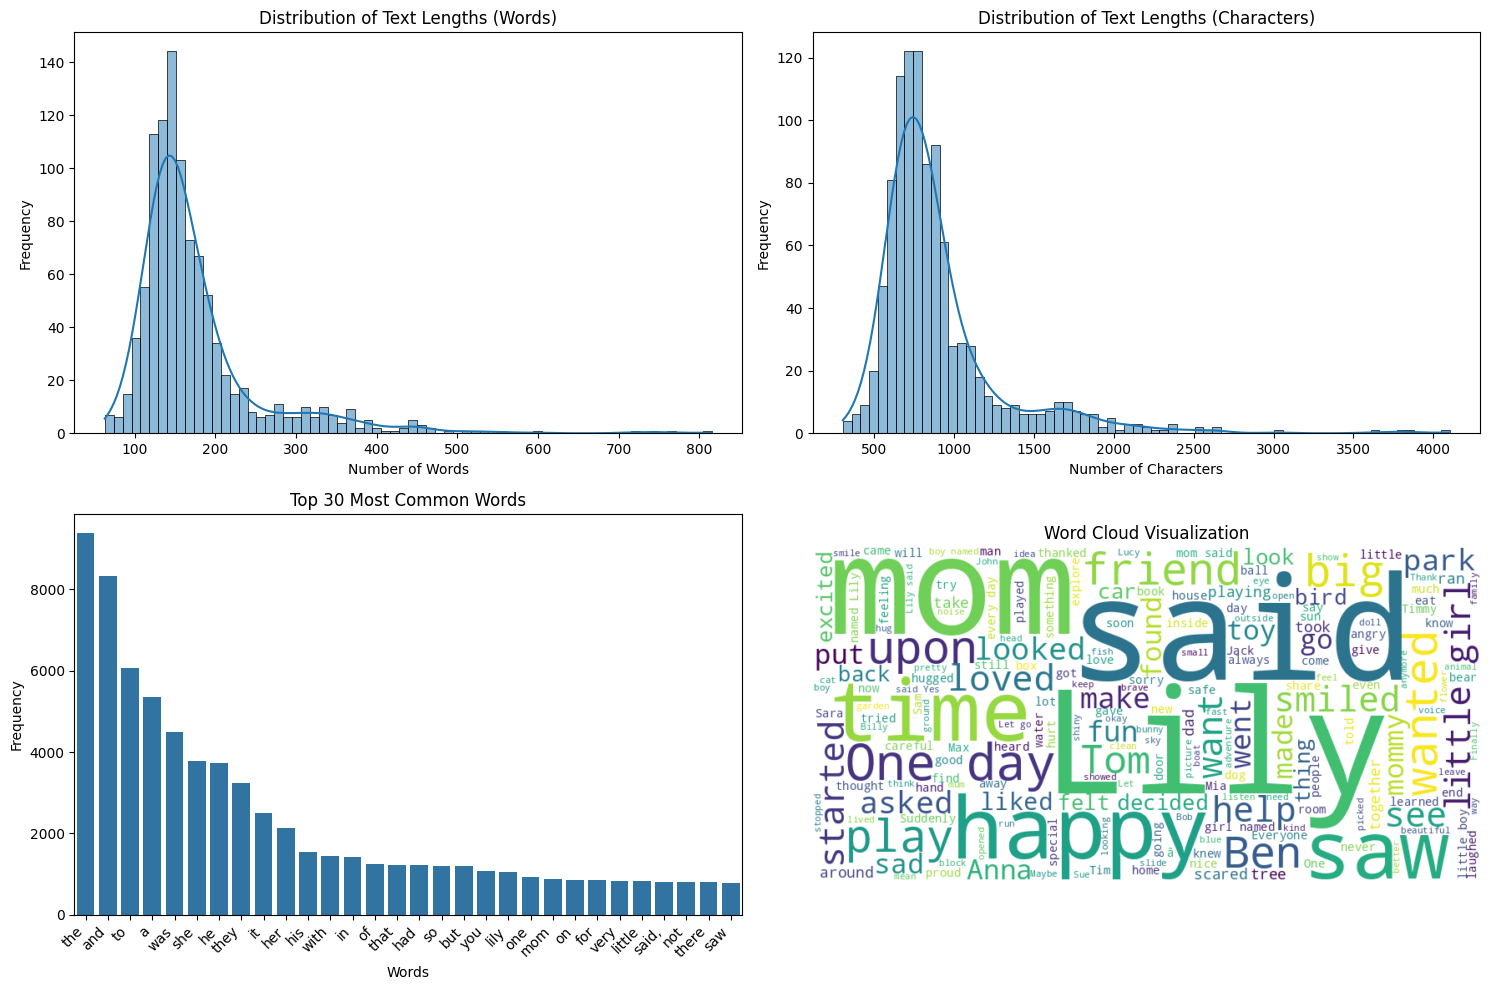

Average text length: 175.83 words
Median text length: 152.00 words
Vocabulary size: 10027 unique words


<Figure size 640x480 with 0 Axes>

Analysis complete!


In [5]:
from explanability import four_pillars
four_pillars.visualize(ds,pillars=[1])

#### Observation

In the first picture of visualizations, we can see that there's a bell shaped distribution cetnered around ~175 words and 152 words which is average and fine to use, majoring of texts are between 100-250 words and some outliers extend to 400+ words. The consistency in story length is well defined and the curve indicates natural variation rather than weird length cutoffs. But why? If you see that our data is of consistent text lengths, it will help our model to learn proper text structure and completion.

##### Understand Why these figures are important

1. **Text length distribution** is our model's reading comprehension blueprint. If 90% of content is ~175 words, our model will excel at concise texts but struggle with longer ones. But why is that? The reason behind this is because transformers process text through positional encodings that map word order to fixed dimensions. If 90% of training data is ~175 words, the model specializes in relationships within this window only, such that position embeddings beyond 200 words become under-trained, kind of like overfitting on concise words only. The self attention mechanism also devevlops length specific sparsity patterns which means, short texts are learned through dense global attention while long texts are learned through localized attention windows (neightboring words). The Memory allocation determines default "attention span" needs, while outliers dictate emergency capacity. Learning rhythm creates steady training batches for smooth gradient flow; the tight cluster (100-250 words) ensures this, while the long tail prevents complacency. If the average text length is around 100-250 words, 85% of attention heads are optimized while if more, 15% heads handle outliers, like a city building 85% of its hospitals in downtown while neglecting suburbs.

2. **Character length distribution** reveals the atomic structure of our text. Short texts under 500 characters optimize tokenization efficiency, while texts over 1000 characters inform batch sizing decisions. Why? Because character counts directly impact tokenization strategies - languages with complex characters (like Chinese) yield fewer tokens per character than space-delimited languages (like English). The distribution shape acts as a processing compass: narrow bell curves enable fixed-length optimization, while bimodal distributions suggest mixed content types requiring adaptive processing. GPU memory allocation becomes predictable with consistent character lengths, while widely varying lengths may require dynamic batching to prevent OOM errors. Character/word ratio variations signal language diversity or specialist terminology that influences vocabulary design. This isn't just counting - it's our model's processing budget blueprint.

3. **Word frequency charts** inventory our dataset's vocabulary landscape. The power-law distribution is fundamental - typically 20% of unique words account for 80% of occurrences. This matters because high-frequency words shape our model's attention patterns most strongly during training. Domain expertise emerges through specialized terminology frequencies. Medical texts show high frequencies of anatomical terms, legal texts prioritize procedural vocabulary - these signature words define what field our model will excel in. The cutoff threshold between common and rare words determines vocabulary size, directly impacting model parameter count. Uncommon words (appearing <5 times) often represent the specialized knowledge edge cases that separate exceptional models from average ones. The long tail isn't just noise - it contains the domain-specific precision terms that enable expert-level responses, while the head contains structural words that define grammatical patterns. Balancing both determines our model's communication style.

4. **The word cloud** transforms frequency data into intuitive visual territory. Size-weighted words reveal conceptual landmarks, but why does this matter? Because human stakeholders process visual patterns faster than numerical tables - the cloud becomes a shared communication bridge between technical and non-technical team members. Visual clustering reveals semantic neighborhoods that might be missed in tabular analysis. Words that appear disproportionately large signal potential concept skew that may bias our model's outputs. The absence of expected domain terms is equally important - these represent blind spots in our training data. Color and positioning aren't just aesthetic choices - they help identify concept clusters and thematic boundaries. Unlike raw statistics, word clouds trigger intuitive pattern recognition, helping identify unexpected relationships between concepts. This visualization serves as both a technical diagnostic tool and an interpretability bridge for explaining our model's knowledge territory to non-technical stakeholders.




### Pillar 2: Semantic Patterns

Analyzing dataset for the four pillars of explainability...

🧩 PILLAR 2: SEMANTIC PATTERNS


<Figure size 2000x2000 with 0 Axes>

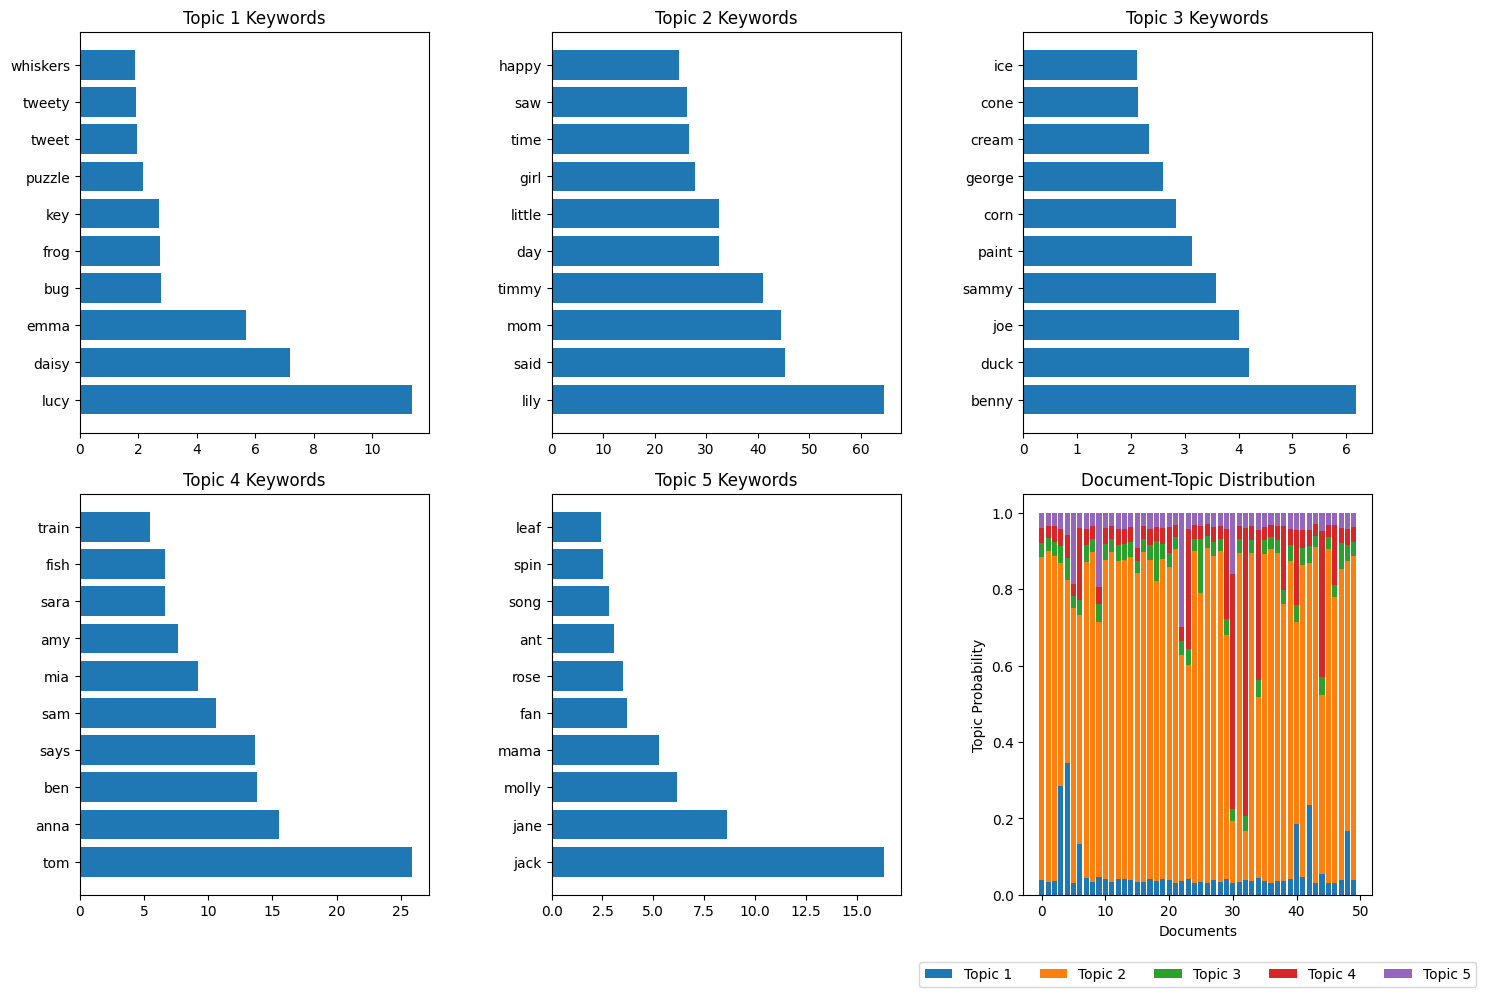

Number of topics analyzed: 5
Top keywords for each topic:
  Topic 1: lucy, daisy, emma, bug, frog
  Topic 2: lily, said, mom, timmy, day
  Topic 3: benny, duck, joe, sammy, paint
  Topic 4: tom, anna, ben, says, sam
  Topic 5: jack, jane, molly, mama, fan


<Figure size 640x480 with 0 Axes>

Analysis complete!


In [6]:
four_pillars.visualize(ds,pillars=[2])

#### Observation

In this Pillar 2 visualization, we can see five distinct topics extracted from the TinyStories dataset. Each topic is characterized by different character names and associated concepts - Topic 1 centers around "lucy" with nature elements like "frog" and "bug," while Topic 2 focuses on family interactions with "lily," "said," "mom," and "timmy." The document-topic distribution shows most stories blend multiple topics rather than focusing on just one, which teaches the model how to transition between themes naturally. This semantic mapping ensures the model learns contextual relationships between words and concepts rather than treating language as isolated tokens, enabling more coherent and contextually appropriate story generation.

##### Understand Why these figures are important

1. **Topic keyword distributions** reveal the conceptual DNA of our training corpus. The image shows 5 distinct topics with character names (lucy, lily, benny, tom, jack) dominating each cluster, signaling character-centric narratives. But why does this matter? Topic modeling helps our LLM understand conceptual relationships between words - "frog" and "bug" appearing in Topic 1 teaches our model these belong to a similar context, creating semantic neighborhoods in embedding space. When our model later encounters "frog," it knows to activate neurons related to similar small creatures. These distributions guide attention patterns during both training and inference: our model learns to predict that after "lucy" and "bug" appear, words like "frog" become more likely. This semantic blueprint prevents hallucinations by establishing valid conceptual connections.

2. **Topic coherence** determines how clearly defined our semantic categories are. Notice how Topic 2 includes "lily," "mom," "said," and "timmy" - suggesting family dialogue scenarios. Strong topic coherence means our model learns tightly bound concept clusters rather than loose associations. Why? Because transformer attention mechanisms operate most effectively when related concepts have clear distinctions and boundaries. Fuzzy topics lead to fuzzy attention, creating generation uncertainty. During fine-tuning, concept-coherent data helps our model develop specialized attention heads that activate for specific semantic domains. Models trained on data with poor topic coherence typically produce outputs that drift between subjects unpredictably.

3. **The document-topic distribution** (colorful vertical bars) maps how topics blend in each document. Most stories contain multiple topics, with orange (Topic 2) appearing most frequently. This pattern matters profoundly because it teaches our model natural topic transitions rather than artificially segmented content. Real stories don't contain just one topic - they weave multiple themes together. The blending proportions (some documents have 70% Topic 2, 30% Topic 4) train our model's internal state transitions, enabling coherent paragraph-to-paragraph flow. Models trained on single-topic documents often generate content that feels unnaturally focused or abruptly switches subjects. This distribution pattern is our model's roadmap for narrative pacing and thematic blending.

4. **Topic balance** across the corpus shapes our model's conceptual priorities. Topic 2 (centered around "lily") dominates many documents while Topic 5 appears less frequently. This imbalance creates an implicit prior in our model - it will naturally gravitate toward generating content similar to dominant topics. Why does this matter? Because unintentional biases in topic distribution become amplified during generation, potentially creating repetitive outputs. The semantic landscape should match our intended generation domain - if creating a diverse storytelling model, you want relatively balanced topics. Recognizing imbalance lets you either rebalance our dataset or implement techniques like topic-weighted loss functions to compensate during training.

5. **Keyword frequency within topics** signals semantic centrality. "Lucy" dominates Topic 1, while "bug" and "frog" appear less frequently. This teaches our model hierarchical concept relationships - primary entities (characters) and their associated attributes or actions. Models learn to structure attention around these hierarchies, making main concepts focal points for generation. This matters because well-structured semantic hierarchies produce more coherent, human-like text with appropriate subject-object relationships. The strongest keyword associations become default patterns our model falls back on when generation uncertainty increases. Understanding these patterns helps explain and predict our model's generation tendencies and failure modes.



### Pillar 3: Linguistic Features

Analyzing dataset for the four pillars of explainability...

📝 PILLAR 3: LINGUISTIC FEATURES


<Figure size 2000x2000 with 0 Axes>

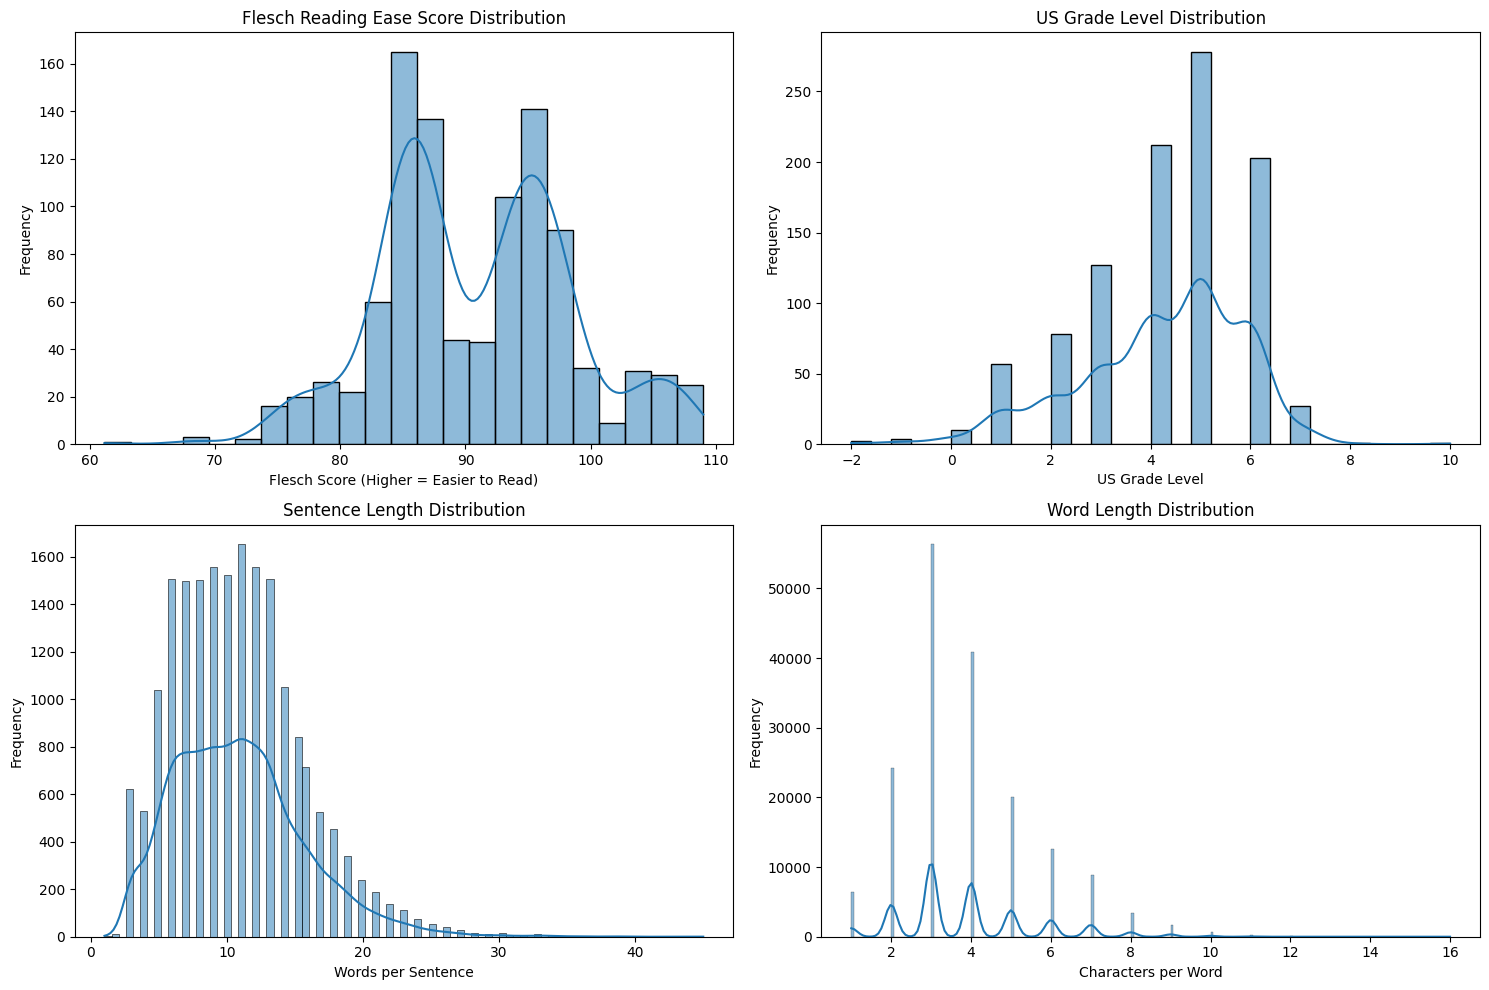

Average Flesch Reading Ease: 90.83 (90-100: Very Easy, 0-30: Very Difficult)
Average US Grade Level: 4.25
Average Sentence Length: 10.87 words
Average Word Length: 3.87 characters


<Figure size 640x480 with 0 Axes>

Analysis complete!


In [7]:
four_pillars.visualize(ds,pillars=[3])

#### Observation
The linguistic features in Pillar 3 reveal a dataset optimized for children's content. The bimodal Flesch score distribution (peaks at 85-90 and 95-100) shows the text maintains very high readability while incorporating some variety in complexity. The US Grade Level concentrating around 4-5 perfectly targets elementary school readers. Sentence structure is consistent and approachable (average 10.87 words), avoiding overly complex constructions that might confuse young readers. The predominantly short word lengths (3.87 characters average) ensure vocabulary accessibility. Together, these features create an ideal linguistic profile for a model designed to generate children's stories that are easy to understand yet still engaging and varied in structure.

##### Understand Why these figures are important
1. **Flesch Reading Ease scores** reveal our dataset's cognitive accessibility profile. The bimodal distribution with peaks at 85-90 and 95-100 indicates two distinct complexity levels within very easy reading material. But why does this matter? Transformer models develop different reasoning pathways when exposed to varied complexity levels. The 95-100 peak texts teach basic language patterns (subject-verb-object, common words, direct statements), while the 85-90 peak introduces slightly more complex structures (compound sentences, broader vocabulary). This linguistic stepping stone approach is crucial because it prevents our model from becoming one-dimensional in its generation style. Without this dual-peak distribution, our model might produce overly simplistic or inconsistently complex outputs. These scores directly influence how our model learns to balance clarity with sophistication - too many complex texts would teach verbose outputs, while too many simple texts would limit expression range.

2. **US Grade Level distribution** maps the educational accessibility of our corpus. The concentration around grades 4-5 (with average 4.25) aligns perfectly with elementary school reading levels. This matters because it determines our model's implicit audience awareness. Models learn implicit tone-audience mapping - grade 2-3 content teaches simple explanations suitable for beginners, while grade 5-6 content demonstrates how to articulate more nuanced concepts. Why is this important? Because models trained exclusively on academic papers (grade 15+) struggle to simplify concepts for general audiences, while those trained on only grade 1-2 texts lack vocabulary for complex topics. The relatively narrow grade range (mostly 3-6) suggests our model will develop consistent educational voice rather than erratic complexity shifts. This educational calibration becomes our model's default communication level during generation.

3. **Sentence Length distribution** reveals our data's syntactic rhythm blueprint. The clearly defined peak around 10-11 words per sentence (average 10.87) shows consistent, approachable sentence structures. This pattern matters deeply because transformers learn optimal attention span patterns from sentence boundaries. Short, consistent sentences teach models to create digestible information chunks rather than overwhelming paragraph-long statements. Each sentence length range teaches different skills: 5-7 word sentences build concise expression, 10-12 word sentences balance detail with clarity, and occasional 15+ word sentences demonstrate complex idea linking. Models trained on wildly varying sentence lengths often generate unpredictable rhythm shifts that feel unnatural. This distribution shapes our model's natural "breath points" during generation - the pauses and breaks that make generated text feel human rather than mechanical.

4. **Word Length distribution** exposes our vocabulary's complexity fingerprint. The spikes at 2-4 characters with average 3.87 characters indicate predominantly simple, accessible vocabulary. But why does this shape our model? Word length directly correlates with language accessibility and concept abstraction. The prevalence of 3-letter words trains our model to prioritize common, concrete terms over specialized vocabulary. Models learn implicit word-complexity associations - shorter words for foundational concepts, longer words for specialized topics. This distribution ensures our model develops a vocabulary appropriate for its target audience (children, based on the grade levels). Models trained on datasets with much higher average word lengths (6+ characters) tend to generate unnecessarily complex or jargon-heavy content, while those trained on only very short words lack precision. our word length profile trains balance between accessibility and precision.

### Pillar 4: Token Relationships


Analyzing dataset for the four pillars of explainability...

🔄 PILLAR 4: TOKEN RELATIONSHIPS


<Figure size 2000x2000 with 0 Axes>

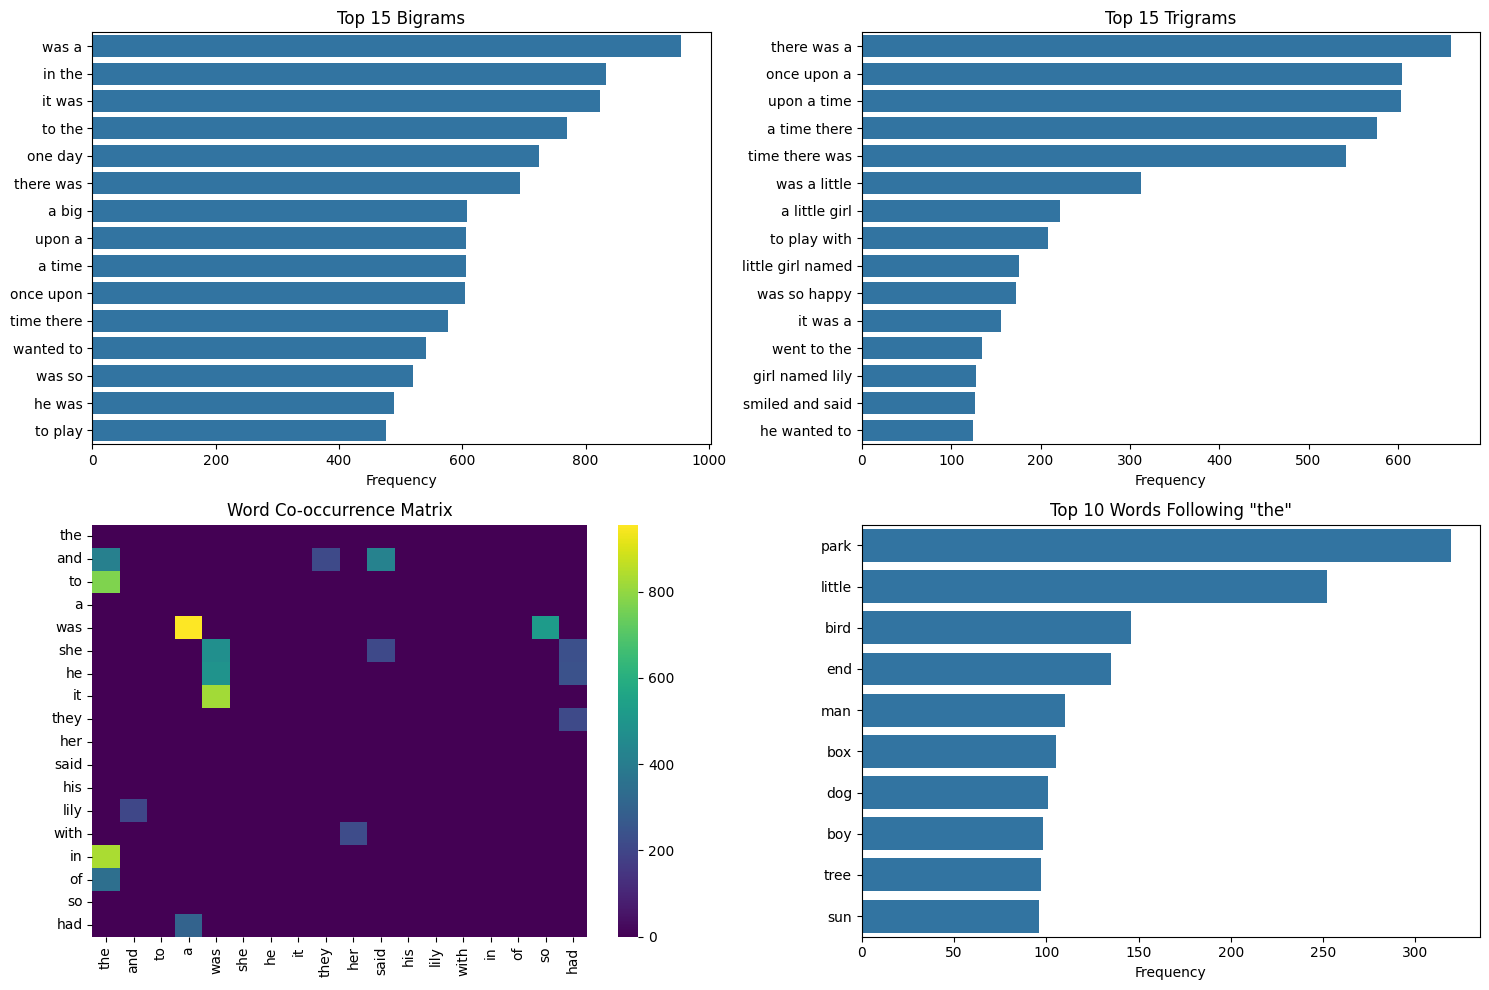

Most common bigram: was a (occurs 955 times)
Most common trigram: there was a (occurs 659 times)
Words most likely to follow 'the': park, little, bird


<Figure size 640x480 with 0 Axes>

Analysis complete!


In [8]:
four_pillars.visualize(ds,pillars=[4])

#### Observation

The visualizations in Pillar 4 show that our dataset is rich in familiar storybook phrases and strong word associations, such as "once upon a time," "there was a," and predictable continuations after common words like "the." The co-occurrence matrix confirms that key characters and actions are tightly linked, reinforcing narrative structure. These patterns ensure our model learns to generate text that is fluent, contextually relevant, and stylistically consistent with children’s stories, rather than producing random or disjointed sequences.

##### Understand Why these figures are important

1. **Bigram and Trigram Frequency** charts (top left and right) reveal the most common two- and three-word sequences in our dataset. Seeing phrases like "was a," "there was a," and "once upon a time" dominate shows that our training data is rich in narrative patterns and storybook language. Why does this matter? These frequent n-grams act as linguistic building blocks-our model learns to generate coherent, natural-sounding sentences by internalizing these common phrase templates. Repeated exposure to such patterns helps the model reliably predict what comes next in a story, improving fluency and narrative flow. If our dataset lacked these recurring structures, the model might generate disjointed or awkward sentences.

2. **Word Co-occurrence Matrix** (bottom left) visualizes how often pairs of words appear together across the corpus. Bright spots indicate strong associations, such as between pronouns ("he," "she") and verbs ("said," "was"), or between characters and their actions. This matters because transformers learn context by modeling how tokens relate to their neighbors. Strong co-occurrence signals help the model understand which words naturally cluster together, reinforcing contextual awareness and thematic consistency. Sparse or random co-occurrence patterns would make it harder for the model to learn meaningful relationships, potentially leading to incoherent outputs.

3. **Top Words Following "the"** (bottom right) highlights the most likely continuations after a common article. Words like "park," "little," and "bird" frequently follow "the," reflecting the story’s subject matter and vocabulary focus. This is important because it shows the model is exposed to realistic, domain-relevant continuations, which will help it generate plausible and contextually appropriate text. If the words following "the" were highly unpredictable or unrelated, it would signal a lack of thematic cohesion in our dataset.

4. **N-gram and Co-occurrence Patterns as Model Guidance**: These token relationships serve as the scaffolding for our model’s language generation. Frequent bigrams and trigrams become the backbone of sentence construction, while strong co-occurrence patterns teach the model how to maintain context over longer passages. This is especially crucial for story generation, where maintaining narrative consistency and logical progression is key.



### Summary
The four pillars collectively form a linguistic DNA profile for our LLM training data:

1. **Distribution Pillar** ensures our model’s "attention span" matches real-world use cases through optimized text lengths.  
2. **Semantic Pillar** builds conceptual coherence by mapping topic relationships and thematic blending.  
3. **Linguistic Pillar** calibrates readability and syntactic patterns for audience-appropriate generation.  
4. **Token Pillar** engineers fluent output through learned phrase templates and word associations.  

Our dataset demonstrates strong foundational suitability for training a children’s story LLM. The text length distribution (100-250 words) aligns with young readers’ attention spans, semantic patterns teach natural topic transitions, linguistic features enforce age-appropriate complexity, and token relationships establish essential storytelling phrases.  

## Step 3 - Training the Model
It's time for training the actual model, let's build it!
